## This notebook visualizes the resutls of "Replay_analysis.ipynb"  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from scipy.ndimage import gaussian_filter1d
from scipy.special import factorial
from scipy.stats import spearmanr
import pftools as pf
import configparser
import os
import matplotlib as mpl
# Initialize the configuration parser
config = configparser.ConfigParser()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Read the configuration file
config.read('config.ini')

# Get the data folder path from the config file
#savefolder= config['paths']['savefolder']
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 16  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 16  # You can adjust the font size as needed
import mtools as mot
import pickle
from scipy.stats import mode
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

# Calculating the p-values for the given z-scores
from scipy import stats
from scipy.stats import wilcoxon

Illustration of the use of these functions
 Mask indexes (burst array indexes): 
 [2, 10, 50] 
Mask indexes expanded to its 2 neighbours: 
 [ 0  1  2  3  4  8  9 10 11 12 48 49 50 51 52] 
Input indexes (array indexes of the positions y or spike positions ysp)
 [3, 7, 12, 30, 51, 100] 
Input indexes excluding those in the set of mask indexes
 [  7  30 100]


In [2]:
import configparser
import os
from pathlib import Path
onfig = configparser.ConfigParser()
# Detect base directory
try:
    BASE_DIR = Path(__file__).resolve().parent  # For scripts
except NameError:
    BASE_DIR = Path.cwd()  # For Jupyter Notebooks

# Move one level up
BASE_DIR = BASE_DIR.parent

# Load config.ini
config = configparser.ConfigParser()
config.read(os.path.join(os.getcwd(), "config.ini"))

# Construct full paths using pathlib and ensure they end with a separator
skeletonsfolder = str((BASE_DIR / config["paths"]["skeletonsfolder"]).resolve()) + os.sep
savefolder = str((BASE_DIR / config["paths"]["savefolder"]).resolve()) + os.sep
datafolder = str((BASE_DIR / config["paths"]["datafolder"]).resolve()) + os.sep

# Print paths to verify
print("Base Directory:", BASE_DIR)
print("Skeletons Folder:", skeletonsfolder)
print("Save Folder:", savefolder)
print("Data Folder:", datafolder)

Base Directory: c:\Users\hamed\Desktop\Hamed\Github\TP7
Skeletons Folder: C:\Users\hamed\Desktop\Hamed\Github\TP7\data\GCaMP6f_478-485\skeleton\
Save Folder: C:\Users\hamed\Desktop\Hamed\Github\TP7\results_new\
Data Folder: C:\Users\hamed\Desktop\Hamed\Github\TP7\data\GCaMP6f_478-485\


In [3]:

plt.rcParams['svg.fonttype'] = 'none'  # Export text as SVG <text> objects, not paths

mpl.rcParams['xtick.major.size'] = 6    # Length of major ticks on x-axis
mpl.rcParams['xtick.major.width'] = 1.5 # Width of major ticks on x-axis
mpl.rcParams['xtick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['xtick.major.pad'] = 10    # Padding between ticks and x-axis labels

mpl.rcParams['ytick.major.size'] = 6    # Length of major ticks on y-axis
mpl.rcParams['ytick.major.width'] = 1.5 # Width of major ticks on y-axis
mpl.rcParams['ytick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['ytick.major.pad'] = 10    # Padding between ticks and y-axis labels


# Set default spine and tick settings globally for all plots
mpl.rcParams['axes.linewidth'] = 1.5     # Set the width of all spines (top, bottom, left, right)
mpl.rcParams['xtick.major.width'] = 1.5  # Width of major ticks on x-axis
mpl.rcParams['ytick.major.width'] = 1.5  # Width of major ticks on y-axis
mpl.rcParams['xtick.labelsize'] = 12     # Font size of x-axis tick labels
mpl.rcParams['ytick.labelsize'] = 12     # Font size of y-axis tick labels

# Define the helper function to hide spines
def hide_spines(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [41]:
phase='learning'
chosen_cell_type='all'


In [42]:
# In this code i load the data from outward runs and find the cells which are place cells.
#burst_len='200ms'
fol='485'
#dir_of_run='L'
#celltype='PC'
celltype='Alltest_neworder'
fs = 20# sampling freq
burst_length=0.5
burst_len=str(burst_length)+'s'
burstsize=burst_length*fs# sample numbers of a burst

In [43]:
#filename = fol+'outward_'+dir_of_run+'_'+phase+'_correct_No_chunk_'+burst_len+'_transients_'+celltype+'_with_templates'
filename = fol+'sampling_L sampling_R outward_L outward_R reward_L reward_R_'+phase+'_correct_No_chunk_'+burst_len+'_transients_'+celltype+'_with_templates'# load all at once reward outward sampling

#filename_reward = fol+'reward_'+dir_of_run+'_'+phase+'_correct_No_chunk_'+burst_len+'_transients_'+celltype+'_with_templates'
#filename_sampling = fol+'sampling_'+dir_of_run+'_'+phase+'_correct_No_chunk_'+burst_len+'_transients_'+celltype+'_with_templates'

#filename = '478outward_R_all_correct_all_days_randomized_bursts_200ms_transients_allnew'

data = np.load(join(savefolder, filename), allow_pickle=True)
#data_reward = np.load(join(savefolder, filename_reward), allow_pickle=True)
#data_sampling = np.load(join(savefolder, filename_sampling), allow_pickle=True)

bound = [0, data['lin_pos'].shape[0]] #if turn_type == 'left' else [sepidx, endind]  

target_cluids=np.unique(data['ids_clust'])

In [44]:
Cell_types=np.load( savefolder+'_Cell_types',allow_pickle=True)
Cluster_types=np.load( savefolder+'_Cluster_types',allow_pickle=True)

TC_clusters=np.concatenate((Cluster_types[phase][fol]['TC_arm'],Cluster_types[phase][fol]['TC_stem']))
PC_clusters=np.concatenate((Cluster_types[phase][fol]['PC_arm'],Cluster_types[phase][fol]['PC_stem']))


In [45]:
all_cluster=np.unique(data['ids_clust'])

all_cluster_tc_removed = np.setdiff1d(all_cluster, TC_clusters)
SI_clusters = np.setdiff1d(all_cluster_tc_removed, PC_clusters)

cluster_types={}
cluster_types['TC_cluster']=TC_clusters
cluster_types['PC_cluster']=PC_clusters
cluster_types['Non_SI_cluster']=SI_clusters



In [46]:

Nshuffles = 500
# Cell type and condition names
#cell_types = ['TC_cells', 'PC_cells', 'Non_SI_cells','All']
cond_names = {
    'sampling_L': 0,
    'sampling_R': 1,
    'outward_L': 2,
    'outward_R': 3,
    'reward_L': 4,
    'reward_R': 5,
    'inward_L': 6,
    'inward_R': 7
}

In [47]:

plt.rcParams['svg.fonttype'] = 'none'  # Export text as SVG <text> objects, not paths

mpl.rcParams['xtick.major.size'] = 6    # Length of major ticks on x-axis
mpl.rcParams['xtick.major.width'] = 1.5 # Width of major ticks on x-axis
mpl.rcParams['xtick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['xtick.major.pad'] = 10    # Padding between ticks and x-axis labels

mpl.rcParams['ytick.major.size'] = 6    # Length of major ticks on y-axis
mpl.rcParams['ytick.major.width'] = 1.5 # Width of major ticks on y-axis
mpl.rcParams['ytick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['ytick.major.pad'] = 10    # Padding between ticks and y-axis labels


# Set default spine and tick settings globally for all plots
mpl.rcParams['axes.linewidth'] = 1.5     # Set the width of all spines (top, bottom, left, right)
mpl.rcParams['xtick.major.width'] = 1.5  # Width of major ticks on x-axis
mpl.rcParams['ytick.major.width'] = 1.5  # Width of major ticks on y-axis
mpl.rcParams['xtick.labelsize'] = 12     # Font size of x-axis tick labels
mpl.rcParams['ytick.labelsize'] = 12     # Font size of y-axis tick labels

# Define the helper function to hide spines
def hide_spines(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [62]:
# load data of Replay_Analysis and visualize the resutls

replay_stats={'learning':{},'learned':{}}
animal_list=['478','481','483','485']
animal_sig_burst_ratio_phase={}
for phase in ['learning','learned']:
    animal_sig_burst_ratio={}
    for aniaml in animal_list:
        #for dir in ['L','R']:
        #for cond in conditions_to_filter:
            
            namefile='Replay'+aniaml+phase
            file2load=savefolder+namefile
            
            replay_stats[phase][aniaml]=np.load(file2load,allow_pickle=True)

            sig_ratios=replay_stats[phase][aniaml]
            animal_sig_burst_ratio[aniaml]=[(cluster,side,metric,sig_ratios[cluster][side][metric][ 'sig_burst_ratio']) for cluster in sig_ratios for side in ['left','right'] for metric in ['sampling_L', 'sampling_R', 'outward_L', 'outward_R', 'reward_L', 'reward_R']]
    animal_sig_burst_ratio_phase[phase]=animal_sig_burst_ratio

In [ ]:
#pvals_pos=[(cluster,side,metric,sig_ratios[cluster][side][metric][ 'pvals_pos']) for cluster in sig_ratios for side in ['left','right'] for metric in ['sampling_L', 'sampling_R', 'outward_L', 'outward_R', 'reward_L', 'reward_R']]

In [63]:
import numpy as np
from scipy.stats import mannwhitneyu

# Step 1: Initialize Rmse dictionary
Rmse = {}

for phase in replay_stats.keys():
    if phase == 'learned':
        for anm in replay_stats[phase].keys():
            for cl_typ in replay_stats[phase][anm].keys():
                for sid in replay_stats[phase][anm][cl_typ].keys():
                    for tsk in replay_stats[phase][anm][cl_typ][sid].keys():
                        # Skip 'inward' task
                        if 'inward' in tsk:
                            continue
                        # Initialize the dictionary for the task and cluster type
                        if cl_typ not in Rmse:
                            Rmse[cl_typ] = {}
                        if tsk not in Rmse[cl_typ]:
                            Rmse[cl_typ][tsk] = []
                        
                        # Add RMSE values to the corresponding task and cluster type
                        Rmse[cl_typ][tsk].extend(replay_stats[phase][anm][cl_typ][sid][tsk]['rmse'])

# Step 2: Merge `_L` and `_R` tasks within each cluster type
merged_Rmse = {}

for cl_typ in Rmse.keys():
    merged_Rmse[cl_typ] = {}
    tasks = list(Rmse[cl_typ].keys())
    
    for tsk in tasks:
        # Identify corresponding "_R" task for each "_L"
        if tsk.endswith('_L'):
            tsk_right = tsk.replace('_L', '_R')
            if tsk_right in tasks:
                # Merge `_L` and `_R`
                merged_Rmse[cl_typ][tsk.replace('_L', '')] = Rmse[cl_typ][tsk] + Rmse[cl_typ][tsk_right]

# Step 3: Merge data across cluster types for each task
merged_tasks_across_clusters = {}

for cl_typ, tasks in merged_Rmse.items():
    for tsk, values in tasks.items():
        if tsk not in merged_tasks_across_clusters:
            merged_tasks_across_clusters[tsk] = []
        merged_tasks_across_clusters[tsk].extend(values)

# Step 4: Perform pairwise statistical tests between tasks
task_keys = list(merged_tasks_across_clusters.keys())
p_values_across_clusters = {}

for i in range(len(task_keys)):
    for j in range(i + 1, len(task_keys)):
        tsk1, tsk2 = task_keys[i], task_keys[j]
        # Perform Mann-Whitney U test
        p_values_across_clusters[f"{tsk1} vs {tsk2}"] = mannwhitneyu(
            merged_tasks_across_clusters[tsk1], merged_tasks_across_clusters[tsk2]
        )

# Step 5: Output Results
print("Merged RMSE Data Across Cluster Types:")
for task, data in merged_tasks_across_clusters.items():
    print(f"{task}: {data}")

print("\nPairwise Statistical Tests (Mann-Whitney U):")
for comparison, result in p_values_across_clusters.items():
    print(f"{comparison}: Statistic={result.statistic}, P-value={result.pvalue}")


Merged RMSE Data Across Cluster Types:
sampling: [0.24529805564669685, 0.3752842598457601, 0.2712832262937032, 0.403489914339049, 0.3940494892776795, 0.4841868005997779, 0.3303267742369332, 0.1808466200955937, 0.29910463188851094, 0.22378995330226342, 0.22657739849858155, 0.27173095938025593, 0.26049152596646374, 0.17379106229416214, 0.4228871760106591, 0.5821256614462943, 0.4066501503645938, 0.39912871646140835, 0.41142715689454096, 0.37343140478926695, 0.4289874970054368, 0.4181695786375173, 0.31785385231738195, 0.406239098883308, 0.4157309827280137, 0.44435693068416593, 0.38735972371370203, 0.2939744886890698, 0.41628890789079376, 0.44877371033355257, 0.31349963516811713, 0.30098481214648876, 0.34043337174056554, 0.38775658171933935, 0.42741062527667645, 0.5971576724067822, 0.46831202105648795, 0.36225367293545124, 0.27363902829051723, 0.3981401609498538, 0.5405231564591916, 0.4219091619522908, 0.37874315045421564, 0.3064589876494262, 0.4845697045964809, 0.17682612261219385, 0.43594

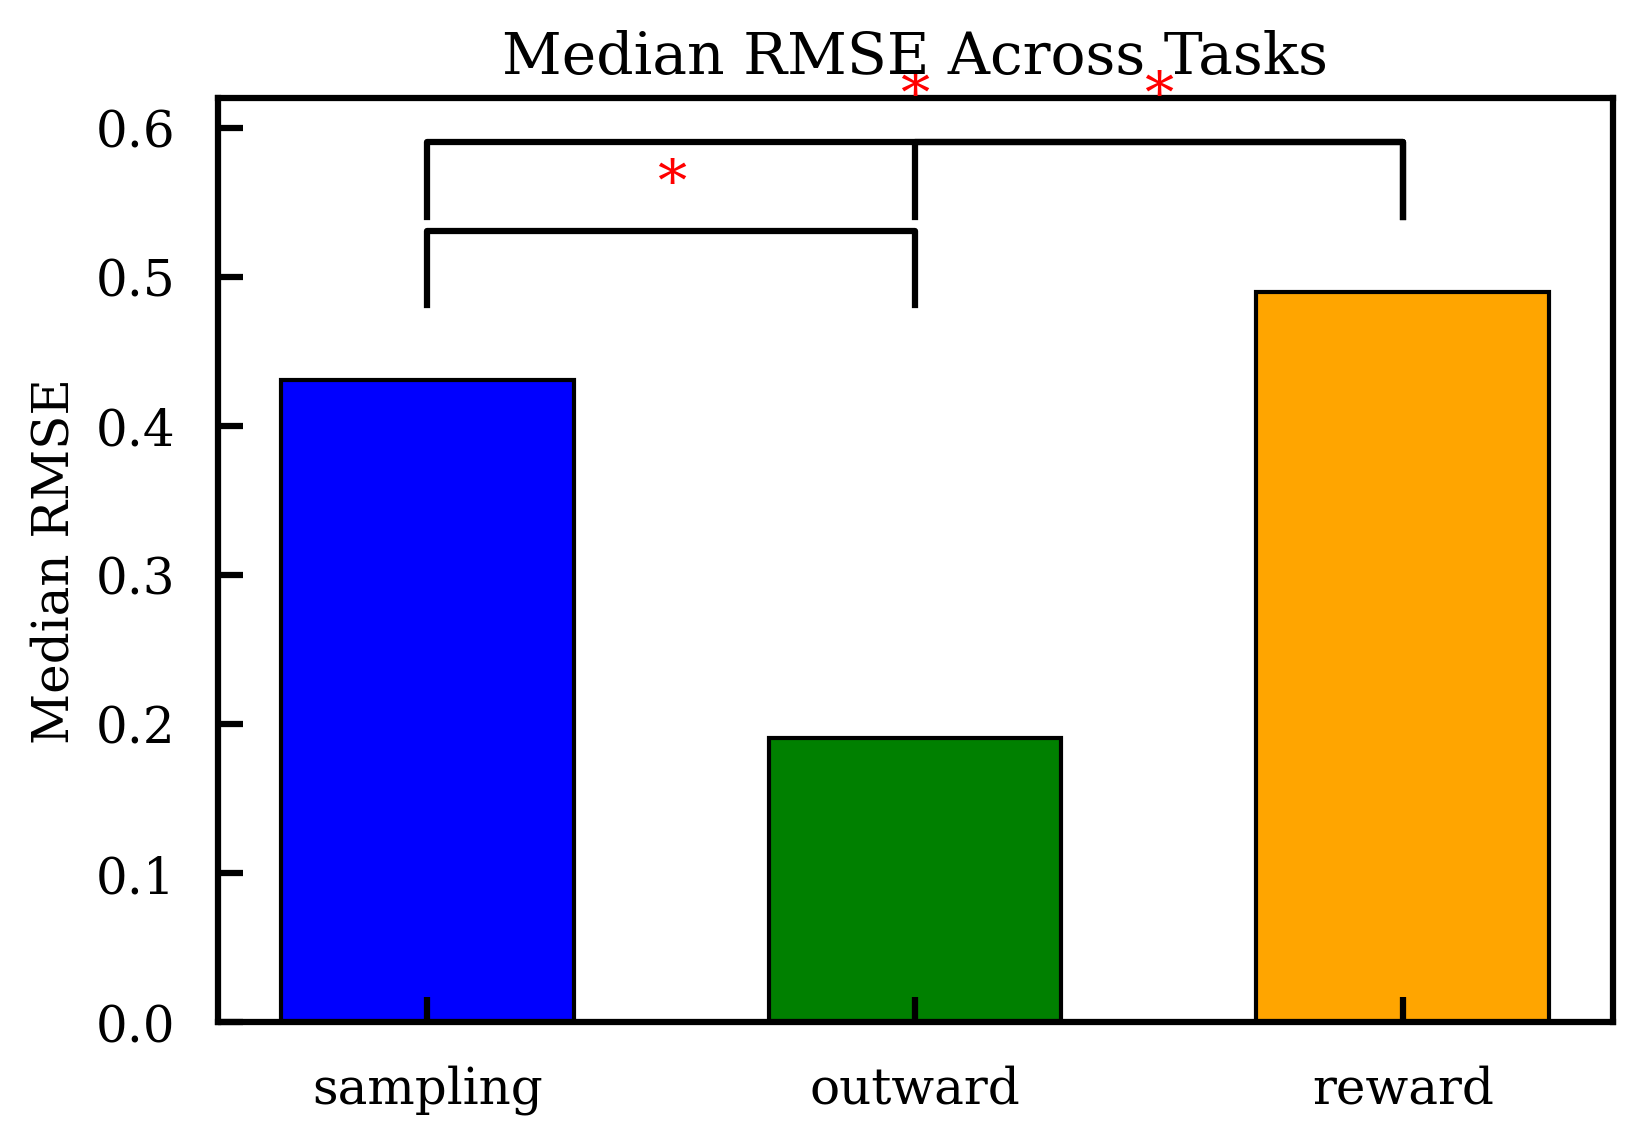

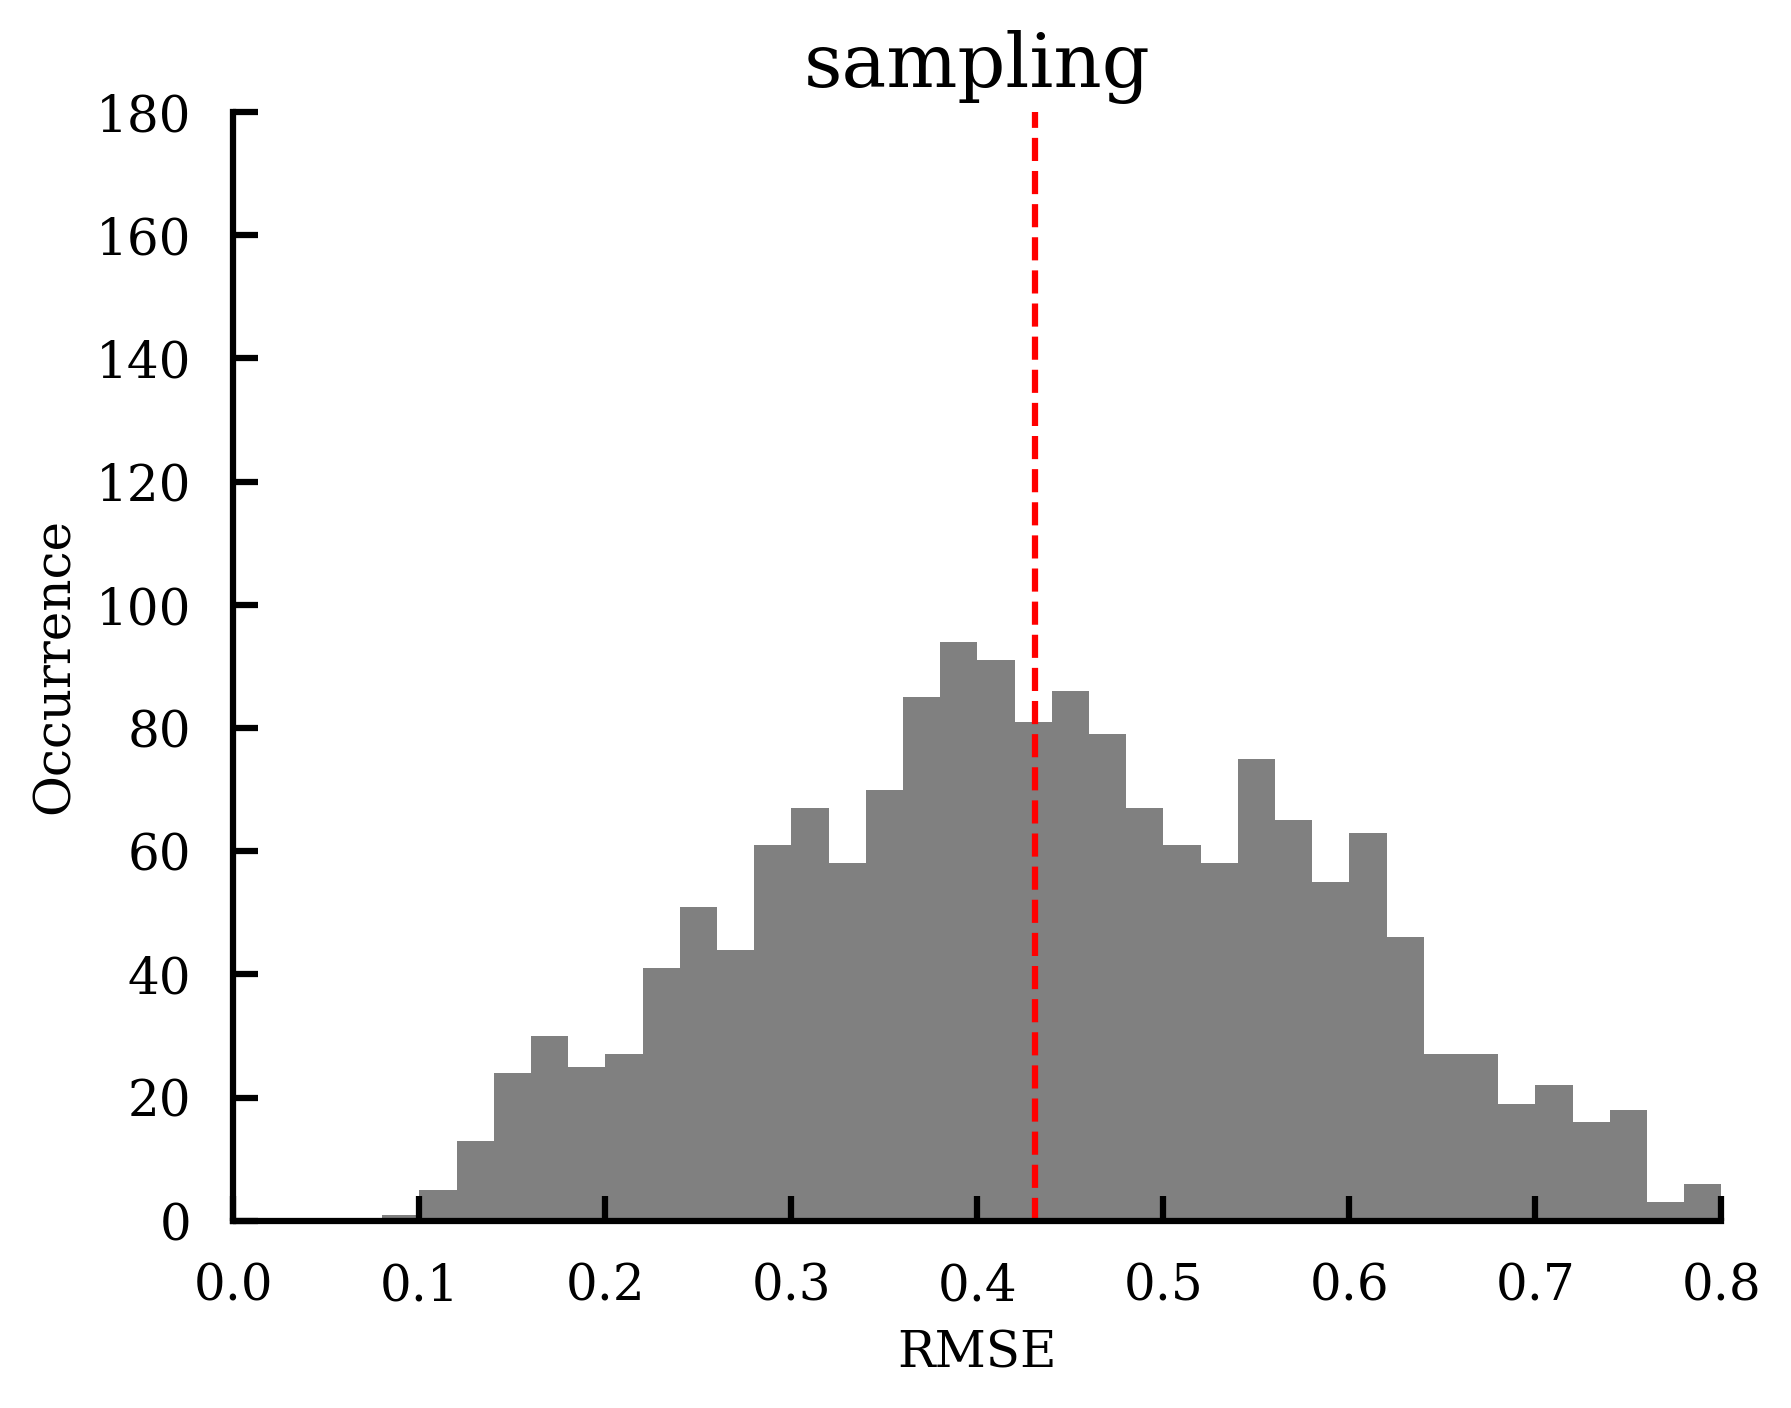

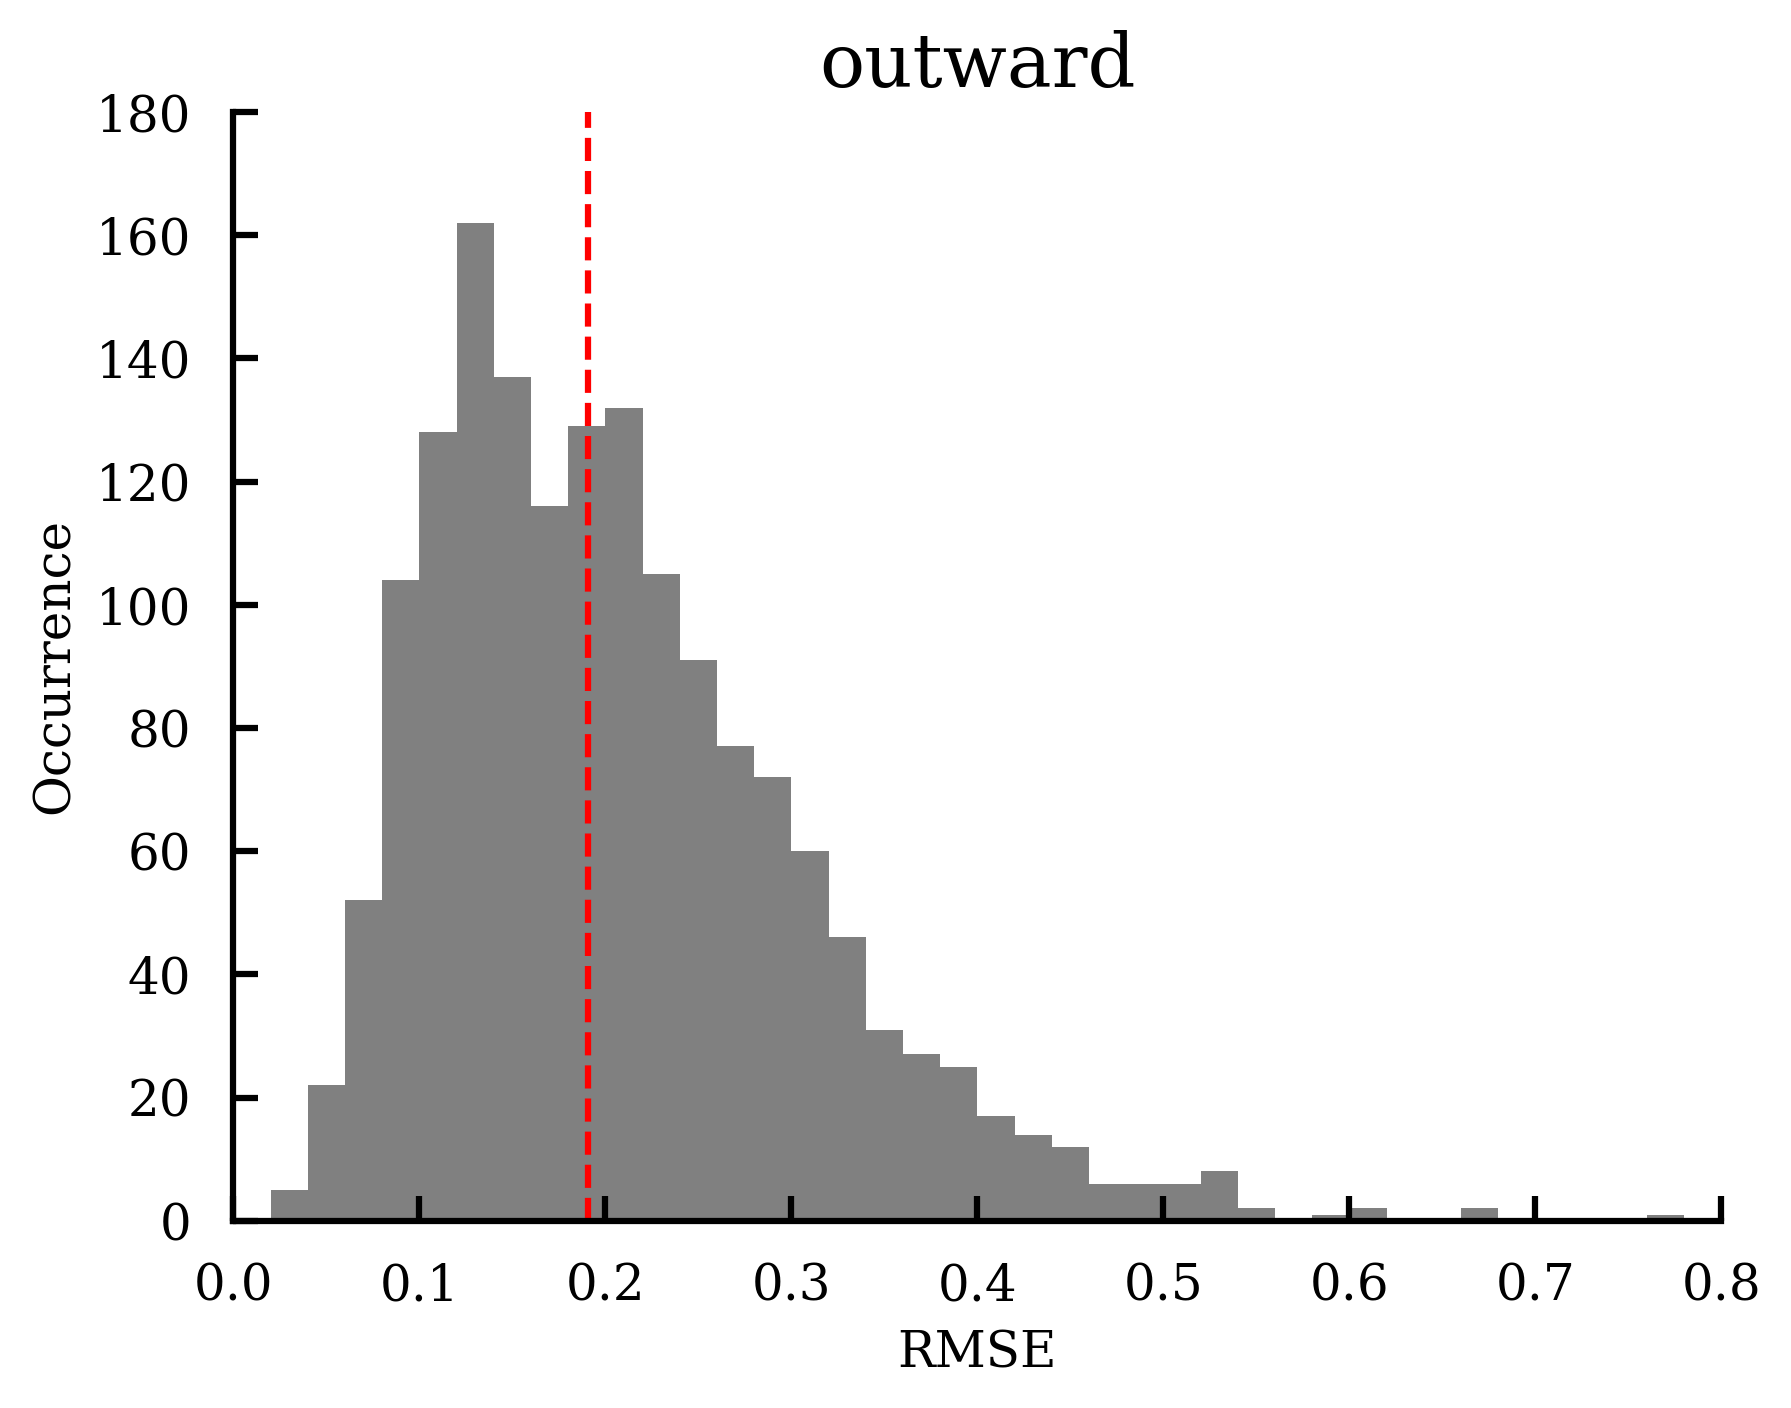

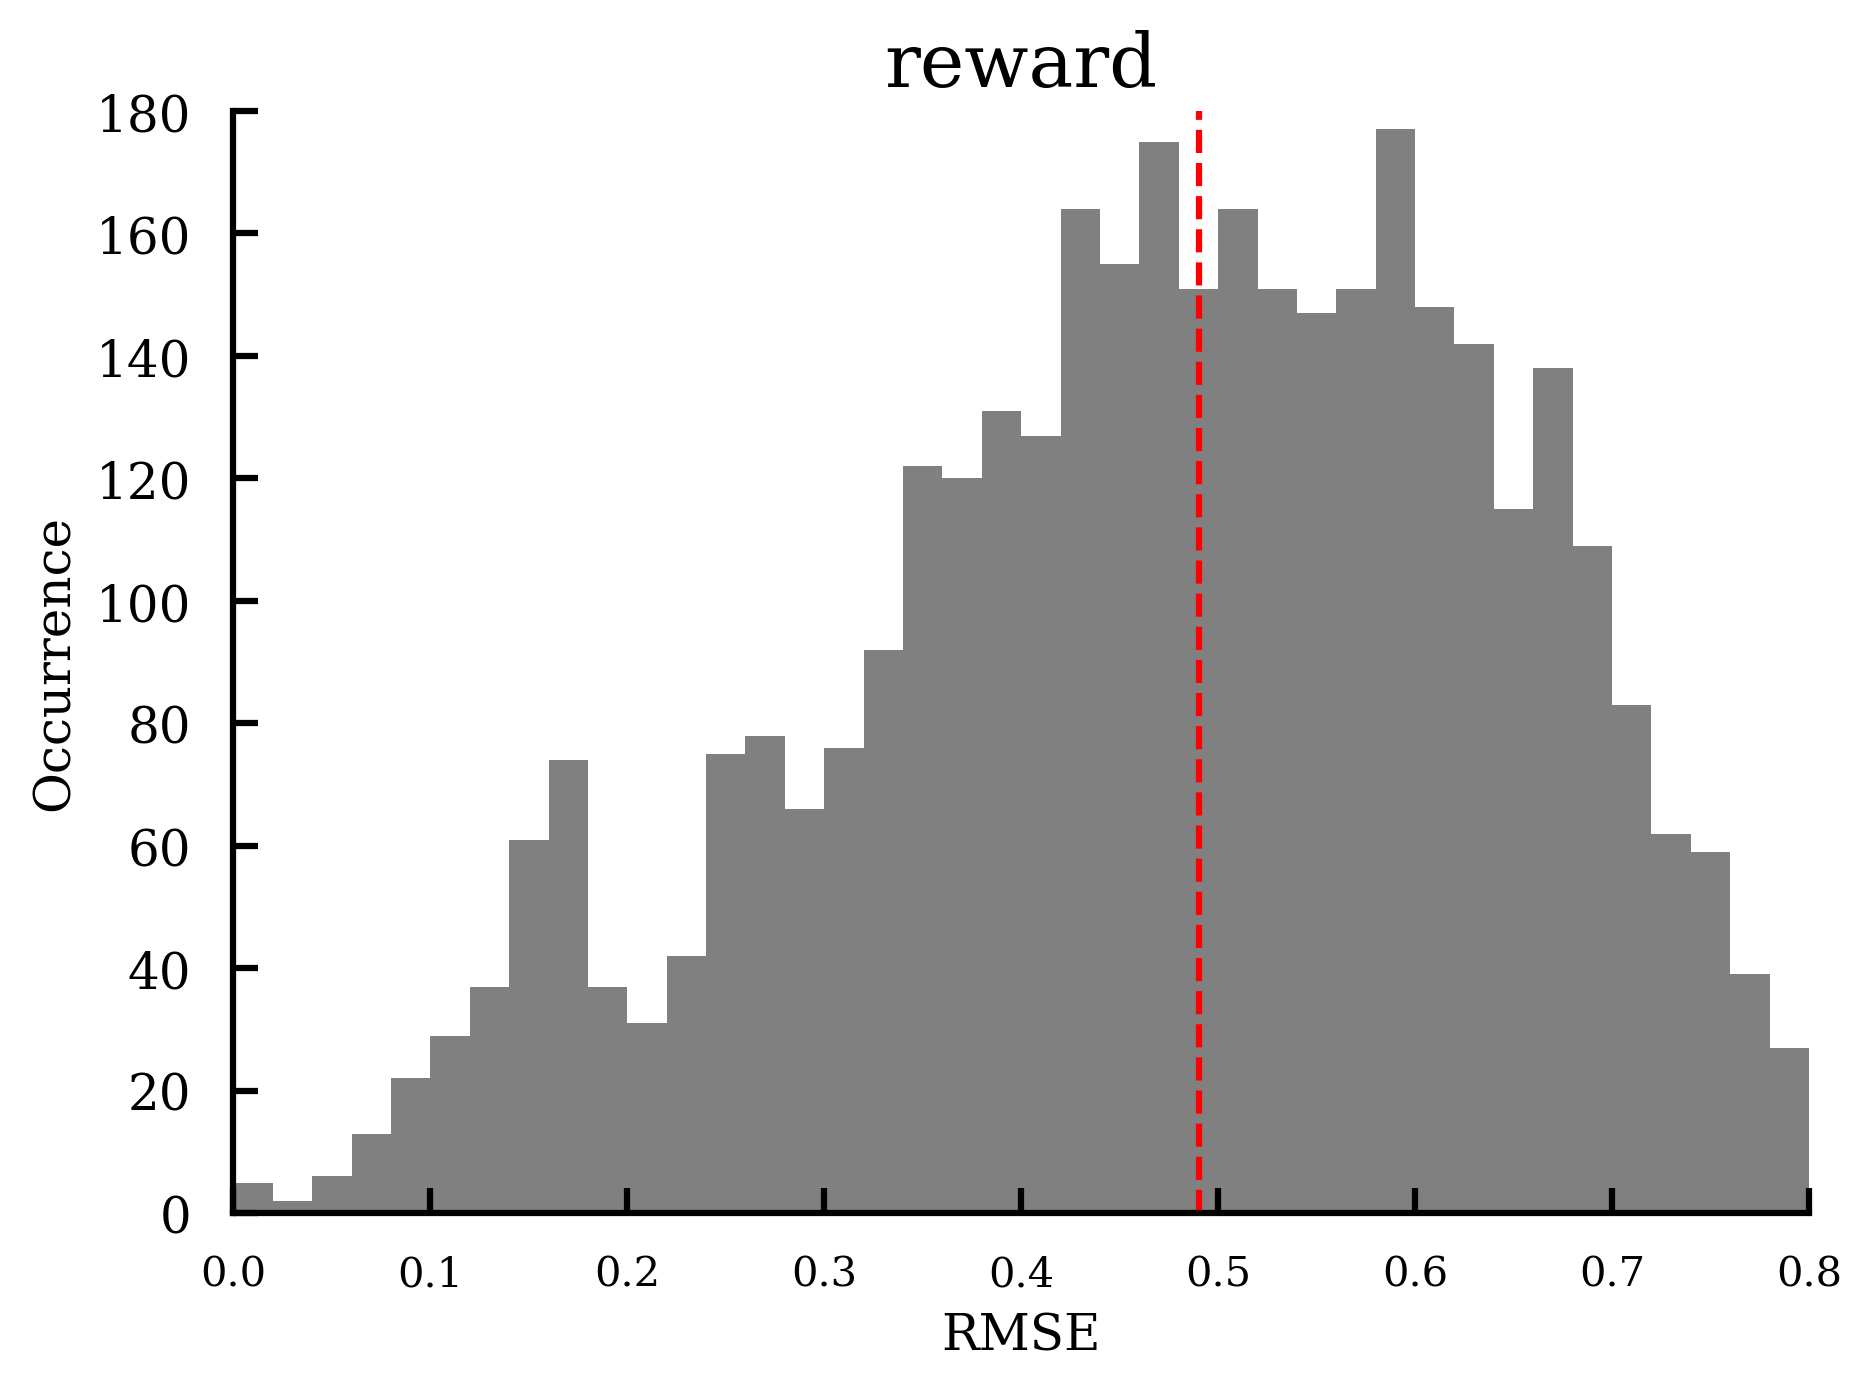

In [64]:
import matplotlib.pyplot as plt

# Step 1: Compute medians for each task
task_medians = {task: np.median(values) for task, values in merged_tasks_across_clusters.items()}

# Step 2: Prepare data for plotting
tasks = list(task_medians.keys())
medians = [task_medians[task] for task in tasks]
colors = ['blue', 'green', 'orange']  # Assign colors for tasks

# Step 3: Plot the bar chart
fig, ax = plt.subplots(figsize=(6, 4))

# Bar chart of medians
bars = ax.bar(tasks, medians, color=colors, edgecolor='k', width=0.6)

# Add individual data points for each task
for i, task in enumerate(tasks):
    y_values = merged_tasks_across_clusters[task]
    x_positions = np.random.normal(i, 0.05, size=len(y_values))  # Add jitter for visualization
    #ax.scatter(x_positions, y_values, color='black', s=20, alpha=0.7)
    plt.figure()
    plt.hist(y_values,bins=np.arange(0,1,.02),color="gray")
    plt.vlines(np.median(y_values),0,200,color='r',linewidth=1.5,linestyle='dashed')
    plt.ylim([0,180])
    plt.xlim([0,.8])
    plt.xlabel('RMSE')
    plt.ylabel('Occurrence')
    hide_spines()

    plt.title(task)
    plt.savefig(savefolder+'RMSE'+task+phase+'.svg',dpi=300)

# Step 4: Add significance stars
y_offset = 0.05  # Offset for star positioning
for comparison, result in p_values_across_clusters.items():
    if result.pvalue < 0.05:  # Significant difference
        task1, task2 = comparison.split(" vs ")
        x1, x2 = tasks.index(task1), tasks.index(task2)
        y = max(medians[x1], medians[x2]) + y_offset
        ax.plot([x1, x1, x2, x2], [y, y + y_offset, y + y_offset, y], color='black', linewidth=1.5)  # Horizontal line
        ax.text((x1 + x2) / 2, y + y_offset + 0.02, '*', ha='center', fontsize=14, color='red')  # Star

# Step 5: Formatting
ax.set_title('Median RMSE Across Tasks', fontsize=14)
ax.set_ylabel('Median RMSE', fontsize=12)

plt.xticks(fontsize=10)
plt.tight_layout()

# Display the plot
plt.show()


In [56]:
#phase='learned'
combined_burst_ratios_df={}
for phase in ['learning', 'learned']:
    # Calculate percentages for all combinations
    all_percentages_tc_left = pf.calculate_all_percentages_merged(replay_stats, phase, 'TC_cluster', 'left')
    all_percentages_tc_right = pf.calculate_all_percentages_merged(replay_stats, phase, 'TC_cluster', 'right')

    all_percentages_pc_left = pf.calculate_all_percentages_merged(replay_stats, phase, 'PC_cluster', 'left')
    all_percentages_pc_right = pf.calculate_all_percentages_merged(replay_stats, phase, 'PC_cluster', 'right')

    all_percentages_non_sig_left = pf.calculate_all_percentages_merged(replay_stats, phase, 'Non_SI_cluster', 'left')
    all_percentages_non_sig_right = pf.calculate_all_percentages_merged(replay_stats, phase, 'Non_SI_cluster', 'right')

    # Combine all results into a single DataFrame for easier analysis
    combined_results = {
        'TC_left': all_percentages_tc_left,
        'TC_right': all_percentages_tc_right,
        'PC_left': all_percentages_pc_left,
        'PC_right': all_percentages_pc_right,
        'Non_SI_left': all_percentages_non_sig_left,
        'Non_SI_right': all_percentages_non_sig_right
    }

    # Convert to a DataFrame
    combined_results_df = pd.concat({k: pd.DataFrame(v).T for k, v in combined_results.items()}, axis=1)
    combined_burst_ratios_df[phase]=combined_results_df


c:\Users\hamed\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\hamed\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\hamed\AppData\Local\Temp\ipykernel_26040\572080186.py:54: RuntimeWarning: invalid value encountered in divide
  pdf_values = counts / (np.sum(counts) * bin_width)


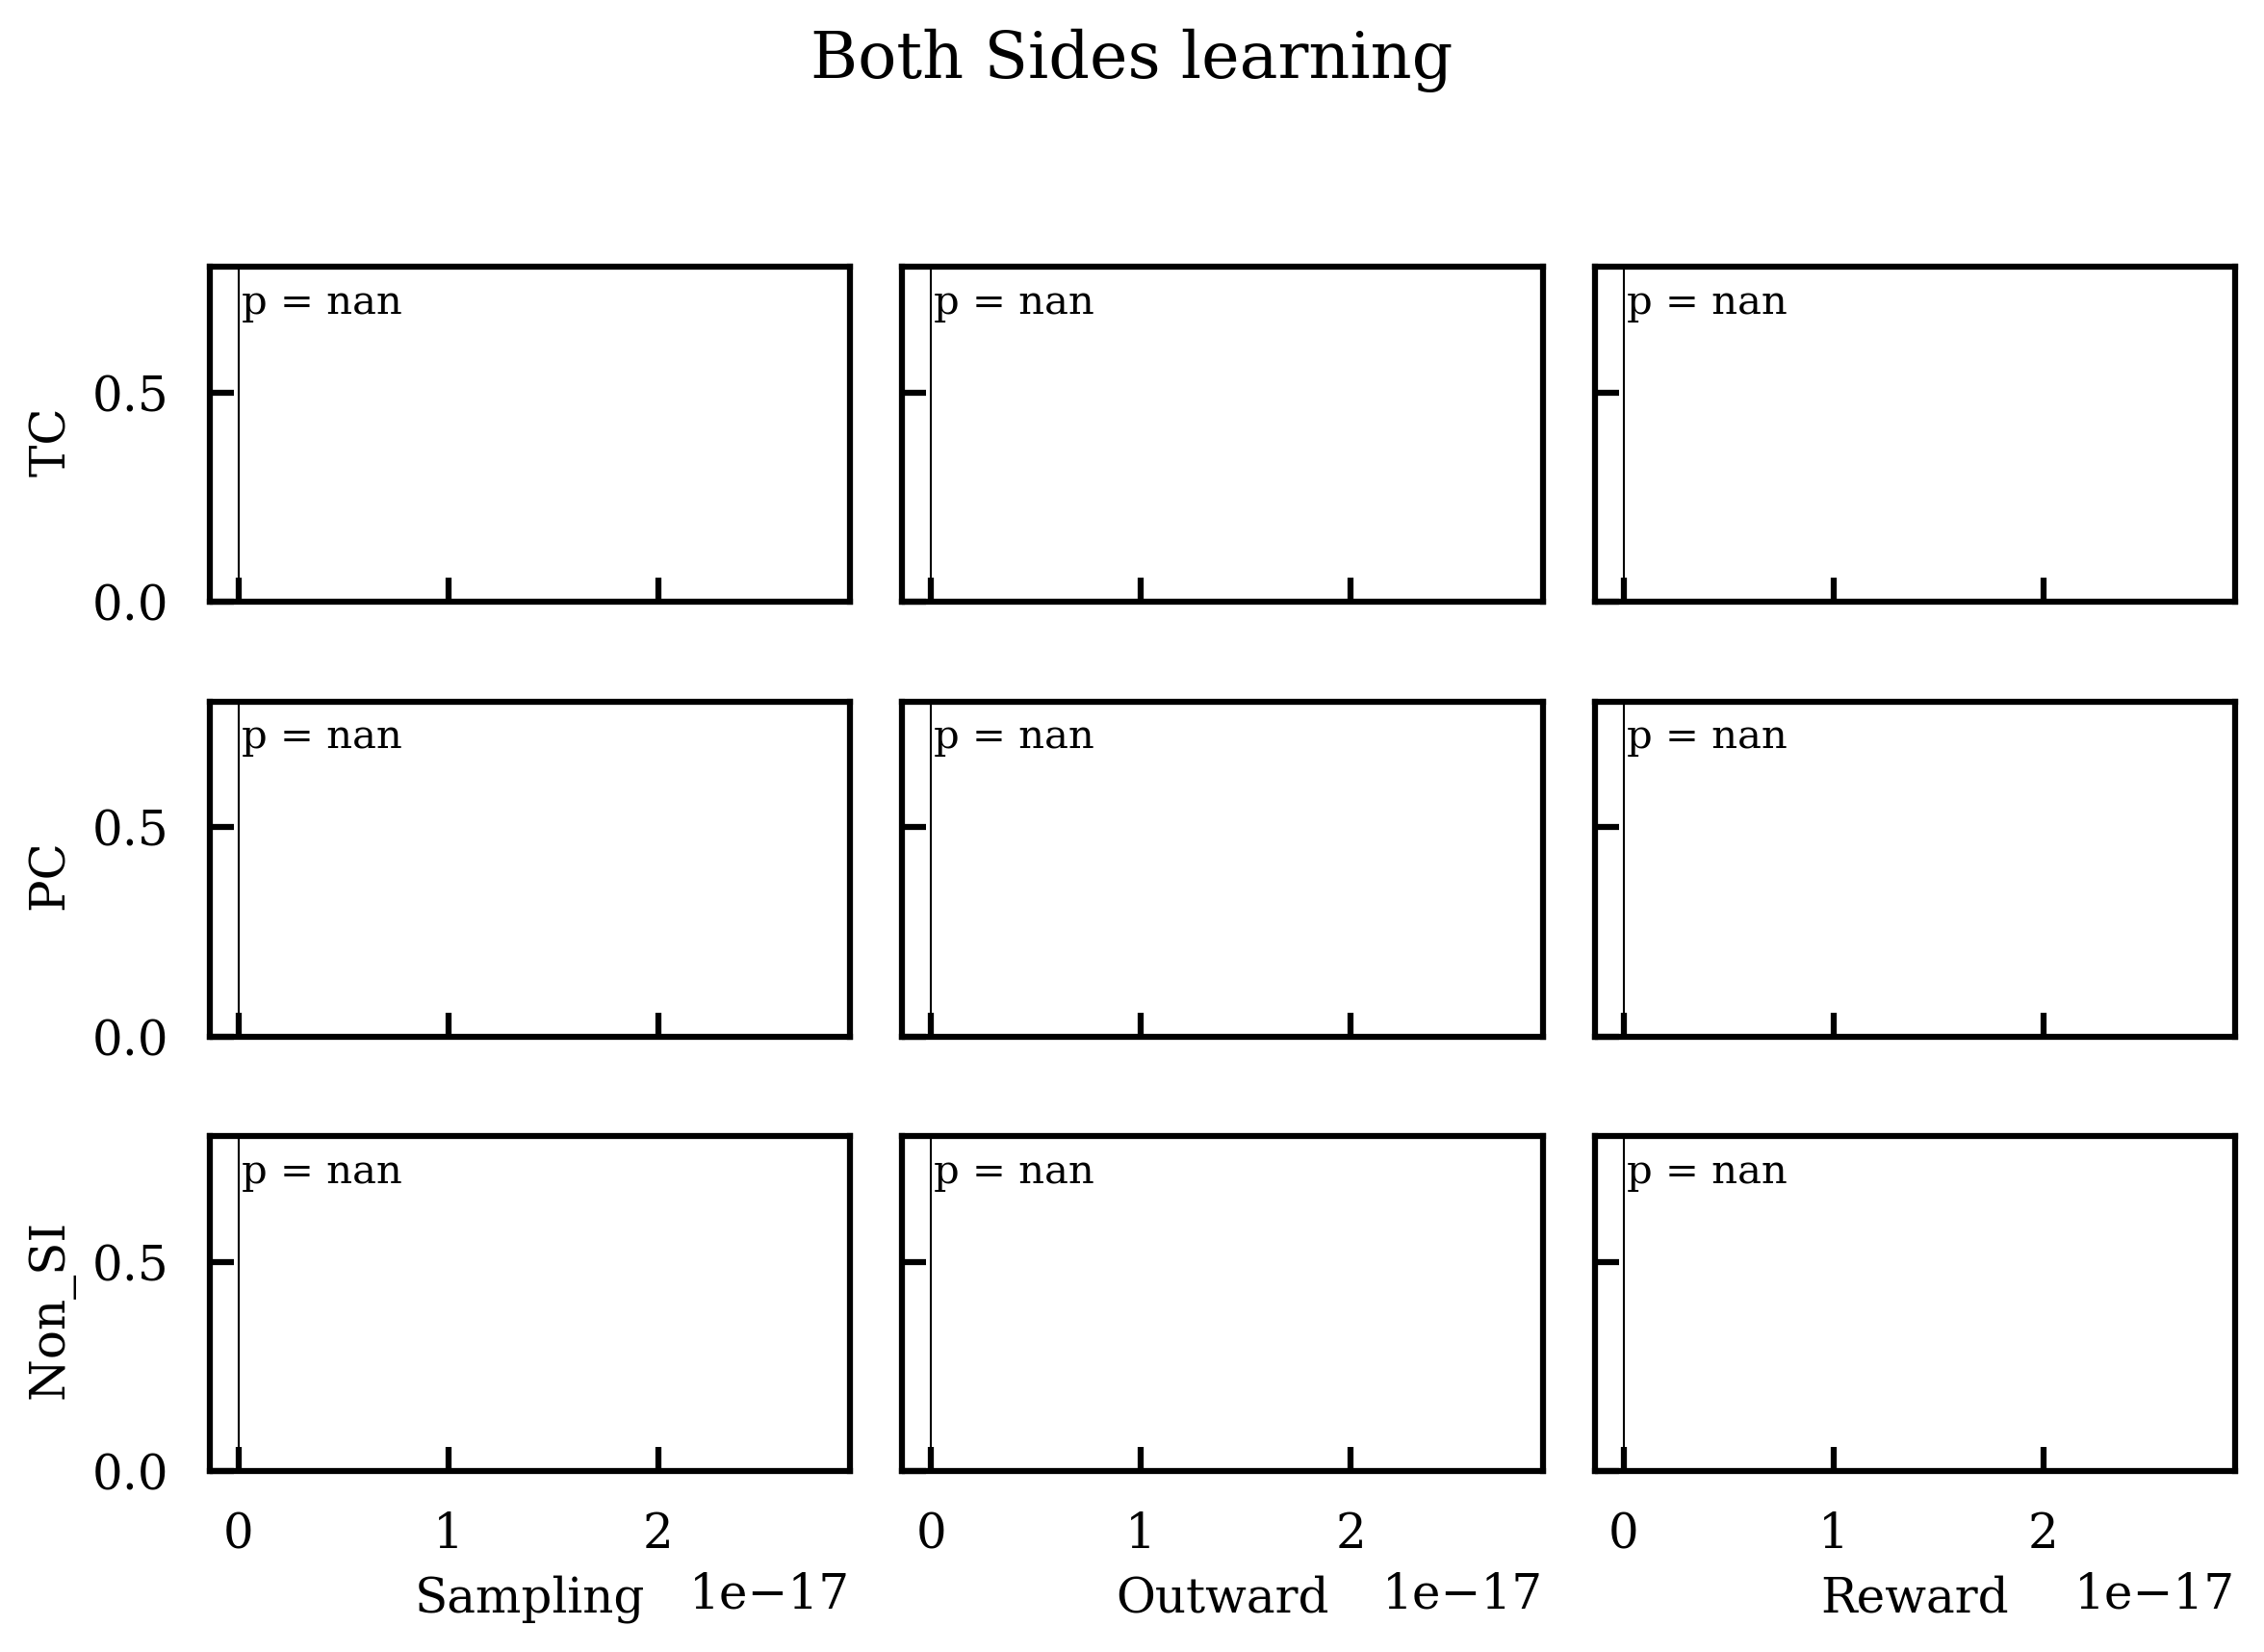

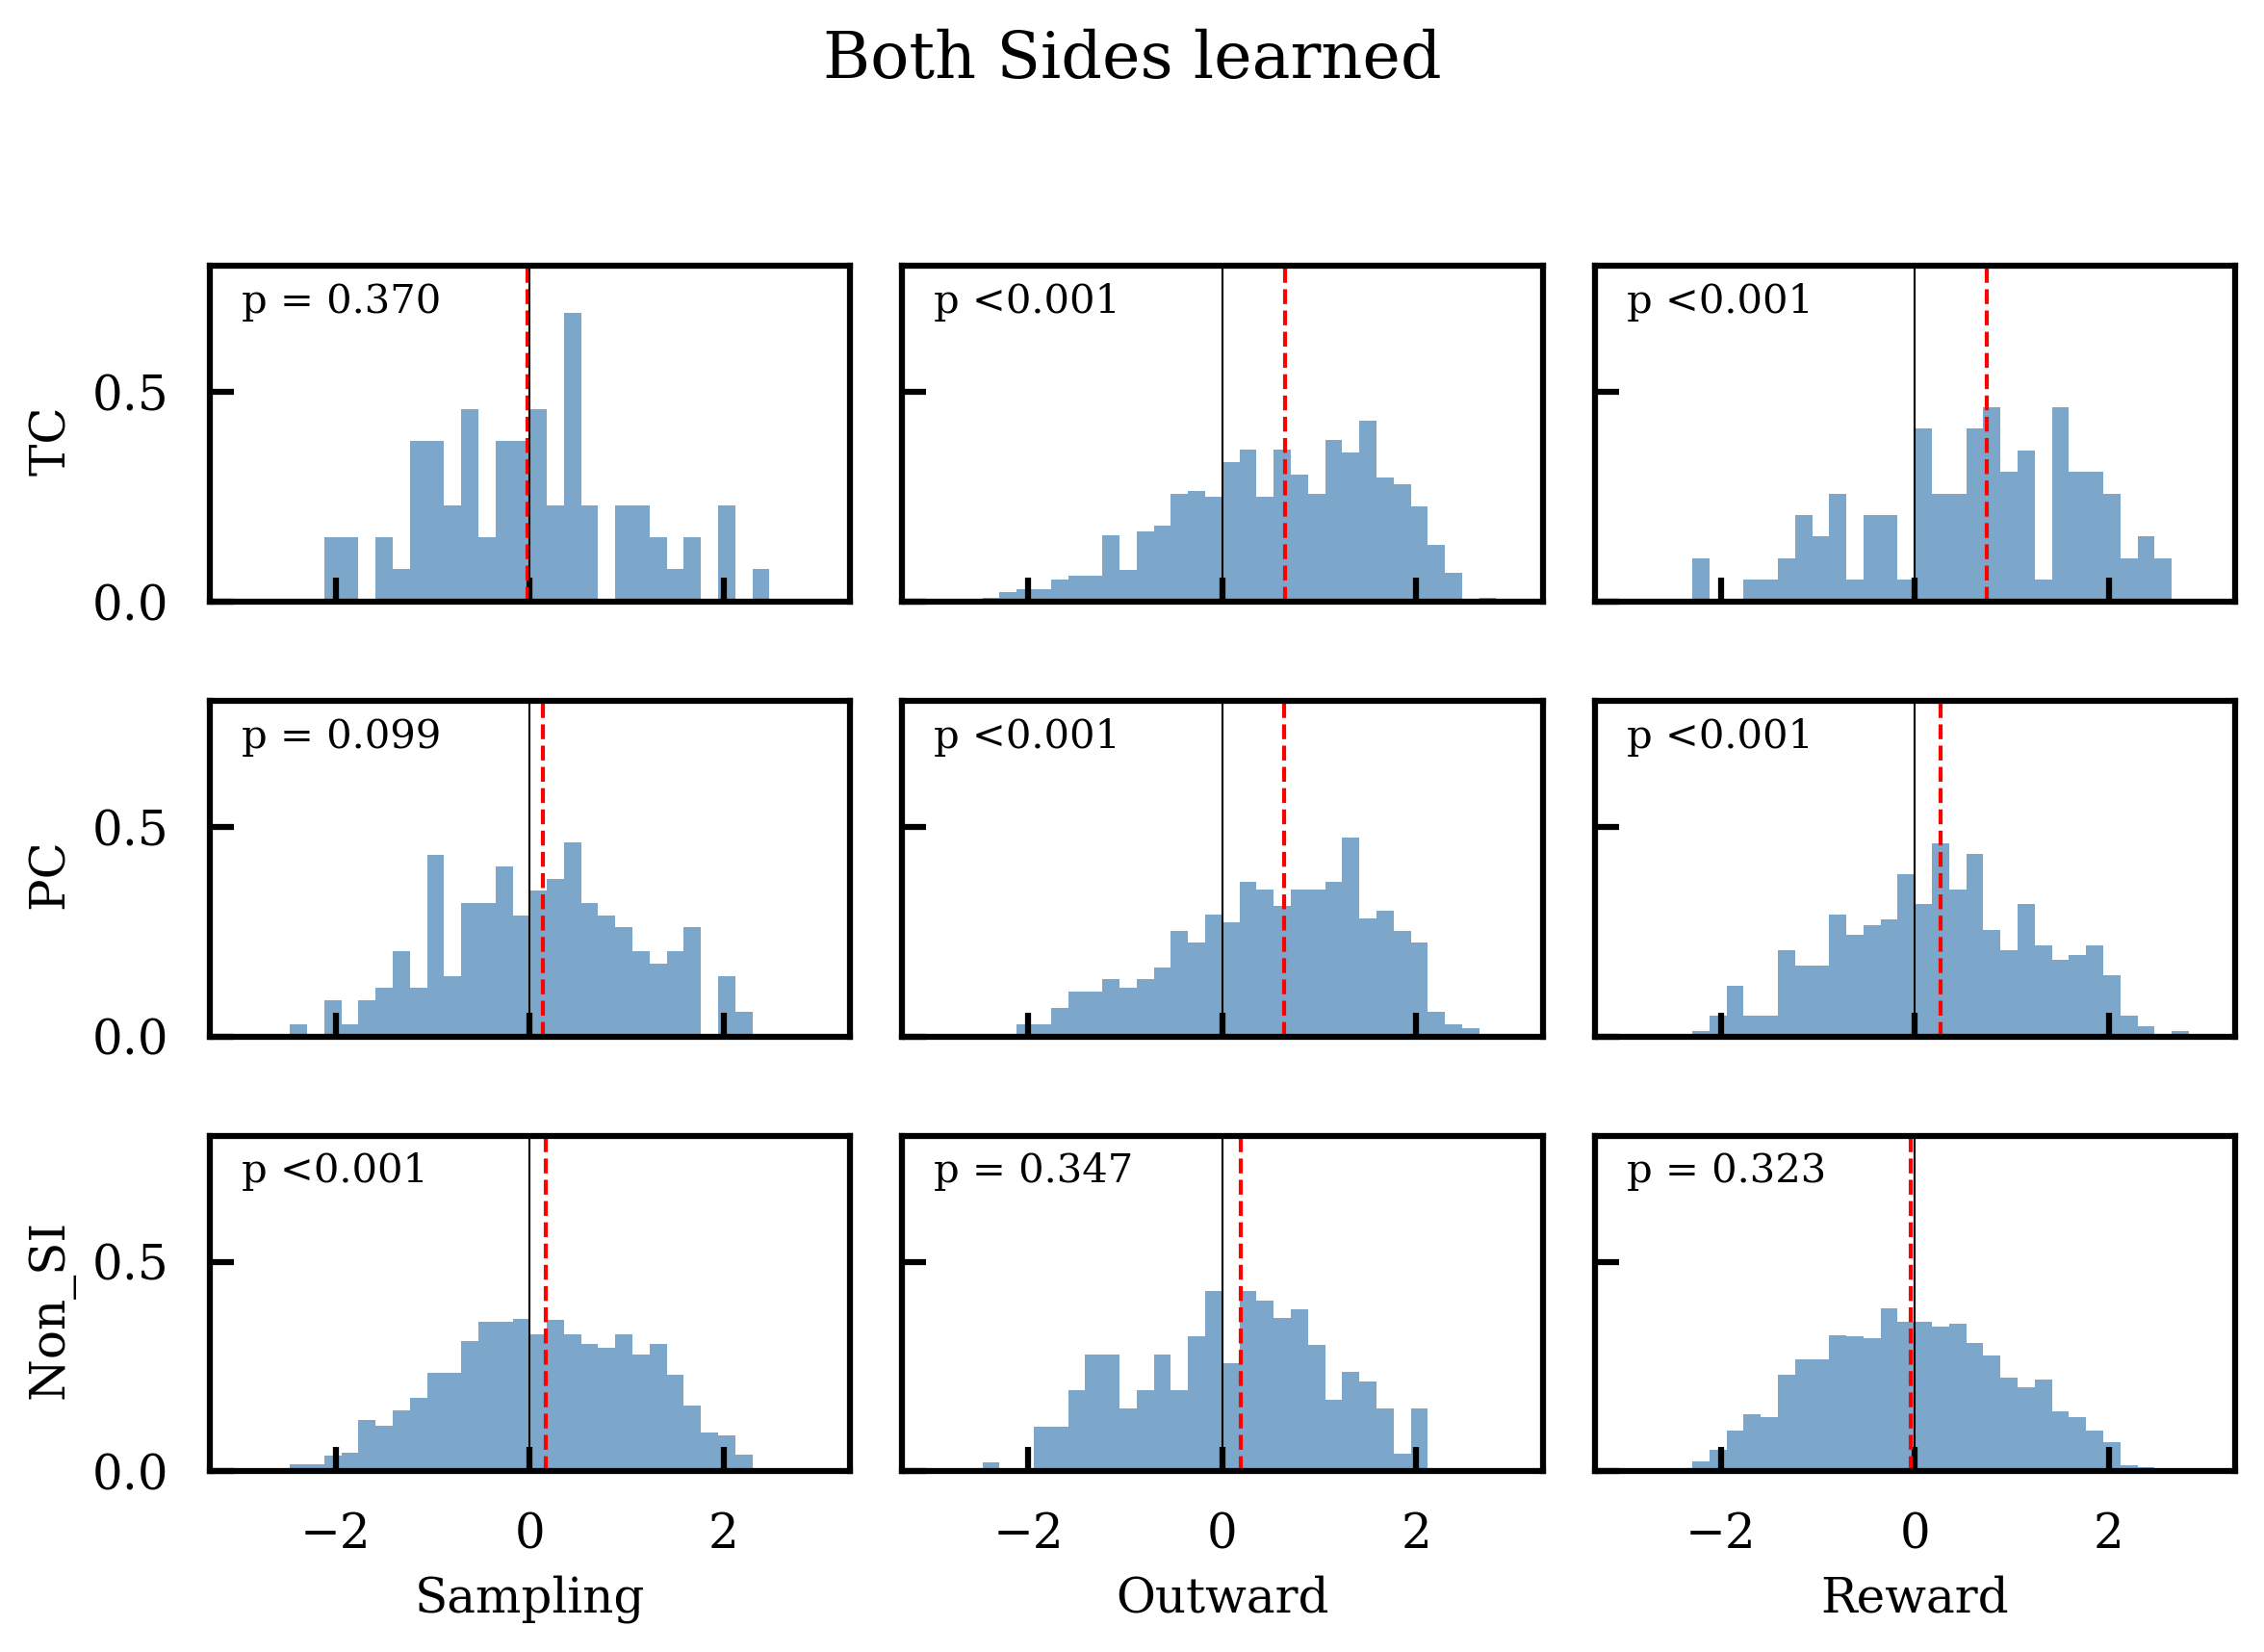

In [ ]:
# get P-values of z-distributions



# Define sides (left and right) to create separate figures
sides = ['left', 'right']
contexts = ['sampling', 'outward', 'reward']
clusters = ['TC_cluster', 'PC_cluster', 'Non_SI_cluster']

pval_all={}
#phase='learned'
# Create separate figures for left and right sides
for phase in ['learning','learned']:
    
    p_values_dict={}
    fig, axes = plt.subplots(len(clusters), len(contexts), figsize=(8, 6), sharex=True, sharey=True)
    fig.suptitle("Both Sides "+phase, fontsize=16)

    for i, cluster in enumerate(clusters):
        for j, context in enumerate(contexts):
            # Extract Z values
            z_values_l = pf.extract_z_values_by_context_cluster_side(replay_stats,phase, context, cluster, 'left')
            z_values_r = pf.extract_z_values_by_context_cluster_side(replay_stats,phase, context, cluster, 'right')
            z_values=np.concatenate((z_values_l,z_values_r))
            z_values=z_values[~np.isnan(z_values)]


            median_value = np.median(z_values)
            axes[i, j].axvline(median_value, color='r', linestyle='--', linewidth=1)
            axes[i, j].axvline(0, color='k', linewidth=.5)
            #axes[i, j].text(median_value, ax.get_ylim()[1] * 0.95, f'Median={median_value:.2f}', ha='center', color='k')

            # Perform a one-sample t-test
            if len(z_values) > 1:  # Ensure there are enough values to perform the test
                #stat, p_value = stats.ttest_1samp(z_values, 0)
                stat, p_value = wilcoxon(z_values_l)


            else:
                p_value = np.nan  # Not enough data

            # Save the p-value in the dictionary
            key = f"{context}_{cluster}"
            p_values_dict[key] = p_value

            # Step 1: Compute histogram
            # Step 1: Compute histogram
            counts, bin_edges = np.histogram(z_values, bins=np.linspace(-3, 3, 35))
            #t_stat, p_value_ttest = stats.ttest_1samp(z_values, 0)
            # Step 2: Compute bin width
            bin_width = bin_edges[1] - bin_edges[0]

            # Step 3: Normalize the counts to compute the PDF
            pdf_values = counts / (np.sum(counts) * bin_width)

            # Step 4: Compute bin centers for plotting
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            # Step 5: Plot the PDF as a histogram of bars
            axes[i, j].bar(bin_centers, pdf_values, width=bin_width, alpha=0.7, color='steelblue')

            # Add p-value text to the plot
            # axes[i, j].text(0.05, 0.95, f"p = {p_value:.3f}", transform=axes[i, j].transAxes, 
            #                 fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))
            if p_value < 0.001:
                p_text = f"p = {p_value:.1e}"  # Scientific notation
                p_text = f"p <0.001"  # Decimal format
            else:
                p_text = f"p = {p_value:.3f}"  # Decimal format
                


            axes[i, j].text(0.05, 0.95, p_text, transform=axes[i, j].transAxes, 
                fontsize=10, verticalalignment='top')
            axes[i, j].set_ylim([0,.8])
            # Plot the histogram
            #axes[i, j].hist(z_values, bins=np.linspace(-3,3,35),density=True, alpha=0.7, edgecolor='black', color='steelblue')
            #axes[i, j].set_title(f"{context.capitalize()}", fontsize=10)
            axes[i, 0].set_ylabel(f"{cluster.replace('_cluster', ' ')}", fontsize=12)

            axes[2, j].set_xlabel(f"{context.capitalize()}", fontsize=12)

            
            #axes[i, j].grid(True)

            # axes[i, j].set_ylim([0,500])
        # Add common labels
        #fig.text(0.5, 0.04, 'Context', ha='center', fontsize=14)
        #fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=14)

    pval_all[phase]=p_values_dict
    plt.savefig(savefolder+'Distribution_z_score_bursts'+phase+'.svg')
        # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

C:\Users\hamed\AppData\Local\Temp\ipykernel_26040\1029522901.py:39: RuntimeWarning: invalid value encountered in divide
  pdf_values = counts / (np.sum(counts) * bin_width)



Results for phase: learning
                         stat  p_value  n
sampling_TC_cluster       NaN      NaN  0
outward_TC_cluster        NaN      NaN  0
reward_TC_cluster         NaN      NaN  0
sampling_PC_cluster       NaN      NaN  0
outward_PC_cluster        NaN      NaN  0
reward_PC_cluster         NaN      NaN  0
sampling_Non_SI_cluster   NaN      NaN  0
outward_Non_SI_cluster    NaN      NaN  0
reward_Non_SI_cluster     NaN      NaN  0

Results for phase: learned
                              stat       p_value     n
sampling_TC_cluster         1320.0  7.161280e-01    74
outward_TC_cluster         59835.0  2.203999e-42   750
reward_TC_cluster           1338.0  3.168185e-07   110
sampling_PC_cluster         8509.0  1.502318e-01   196
outward_PC_cluster         38882.0  3.908528e-30   584
reward_PC_cluster          40571.0  1.030829e-06   468
sampling_Non_SI_cluster   399035.0  1.585415e-09  1400
outward_Non_SI_cluster     15513.0  1.113711e-01   264
reward_Non_SI_cluster    227

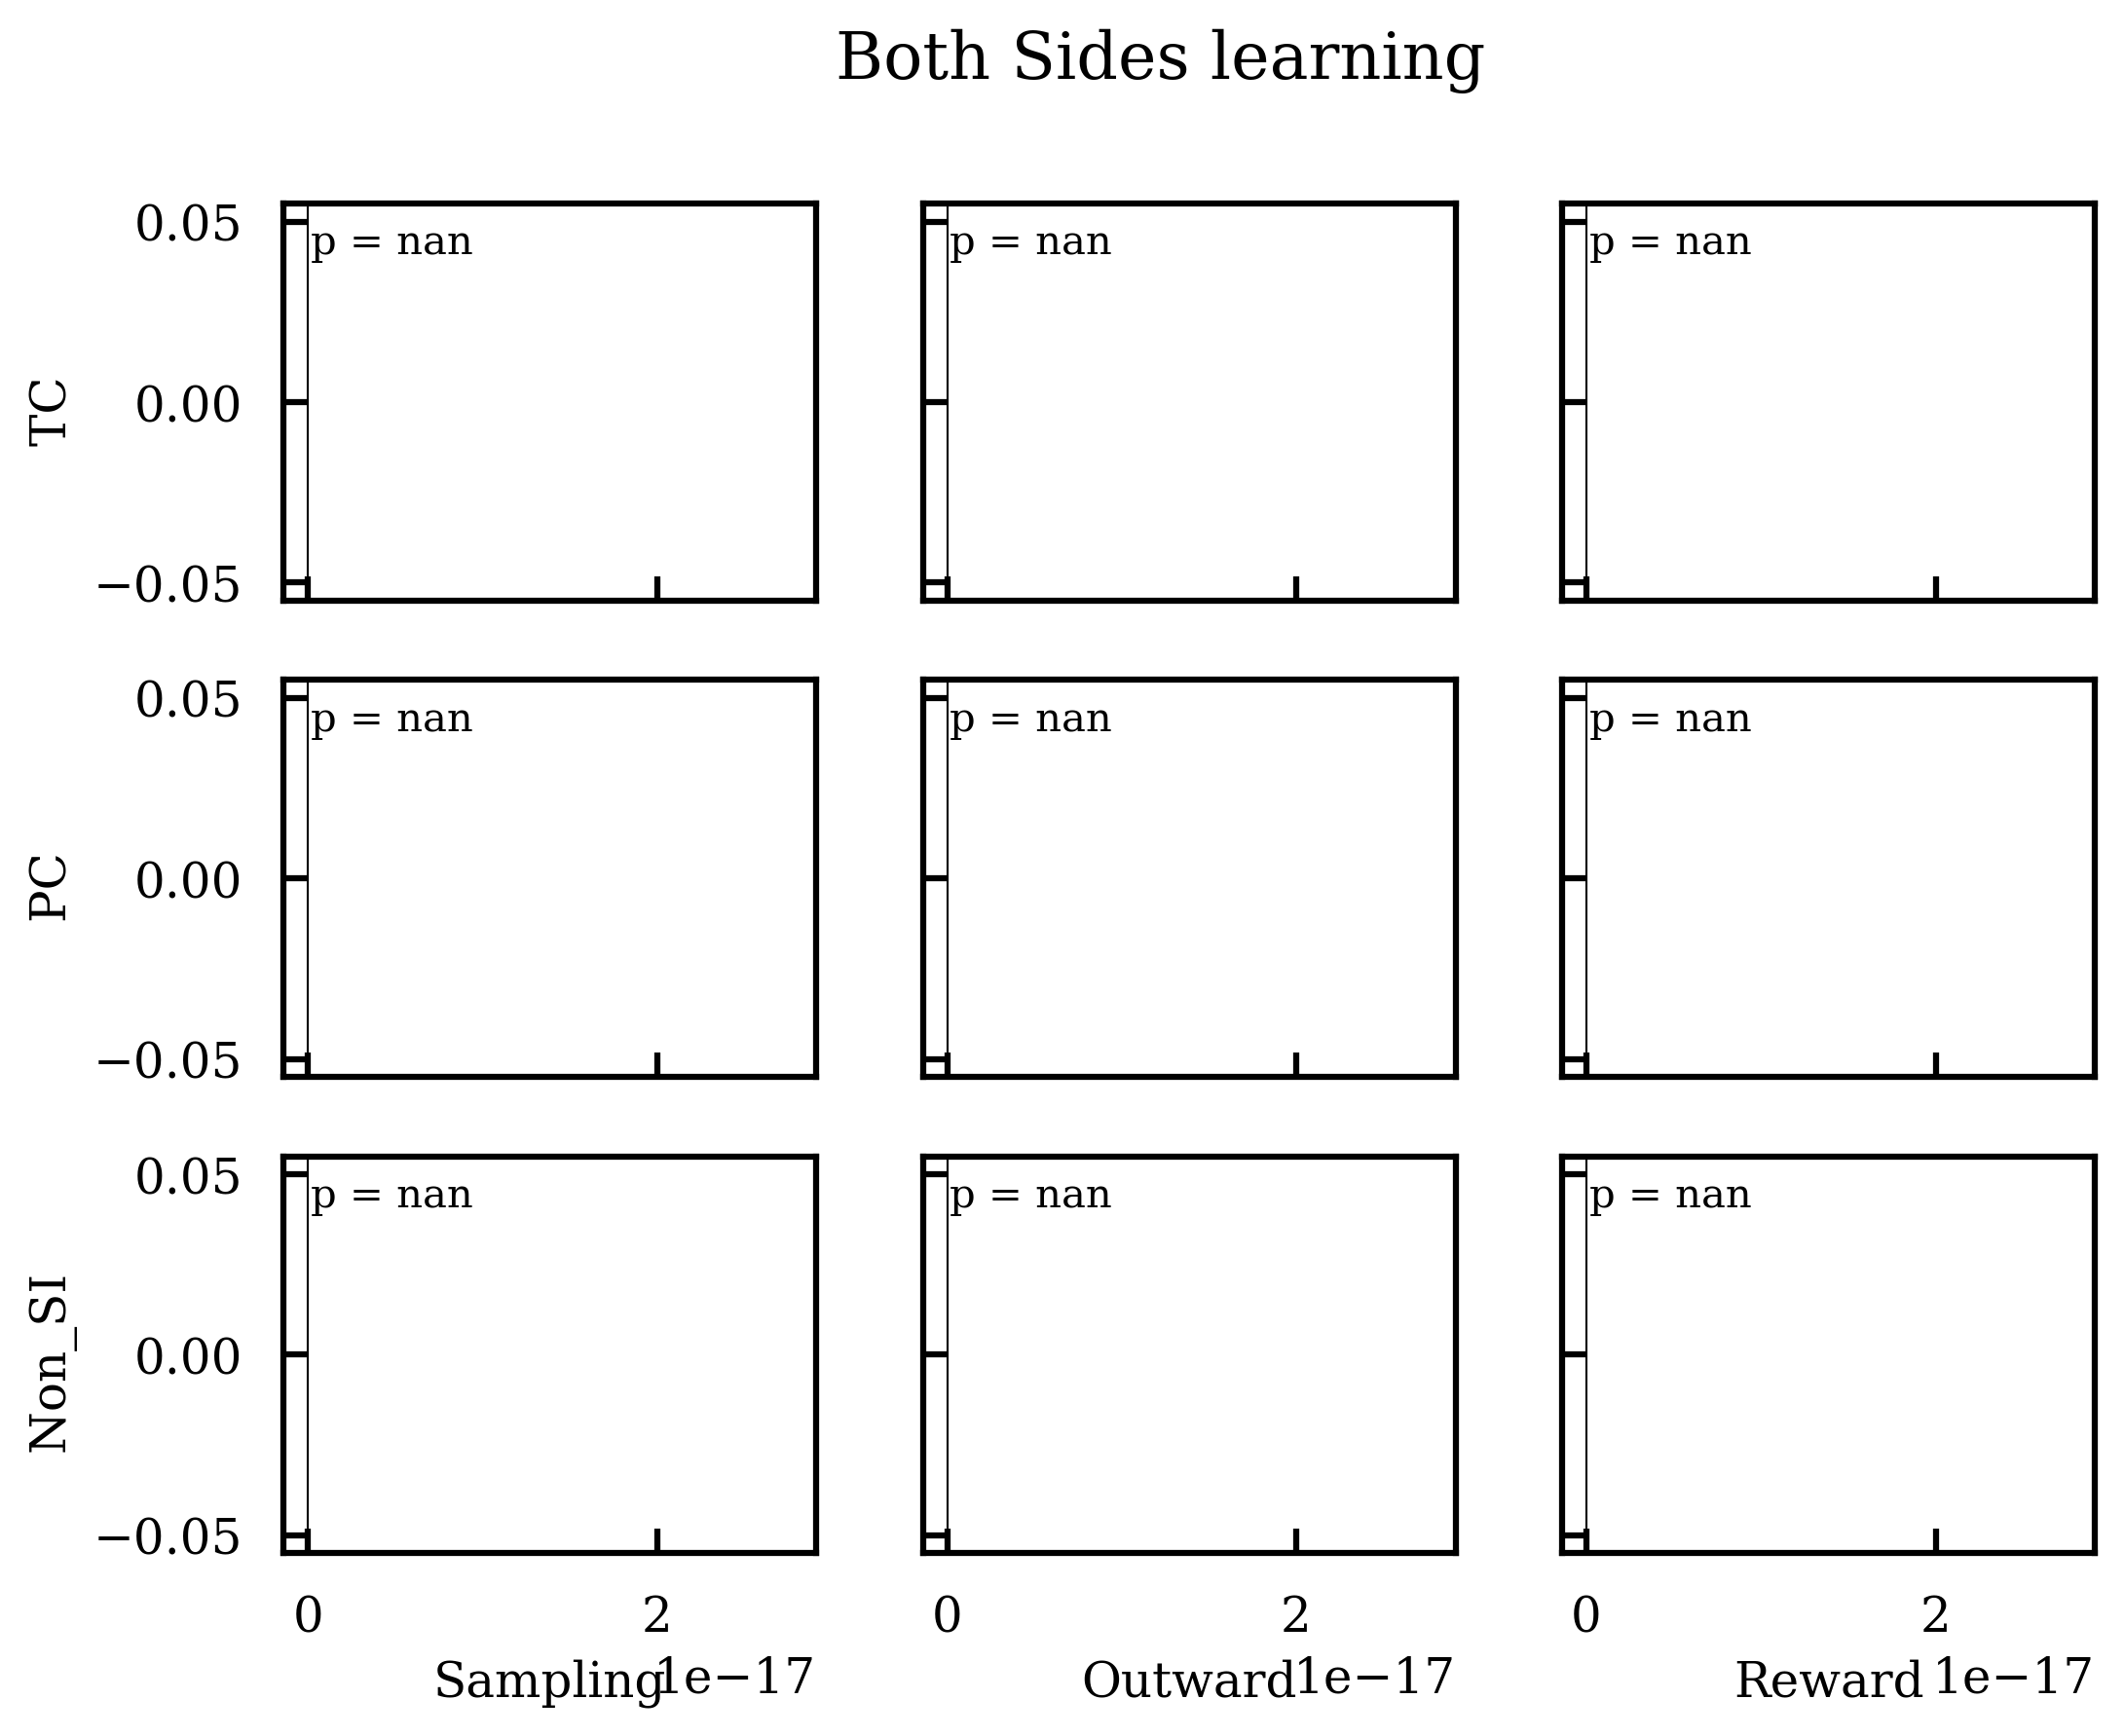

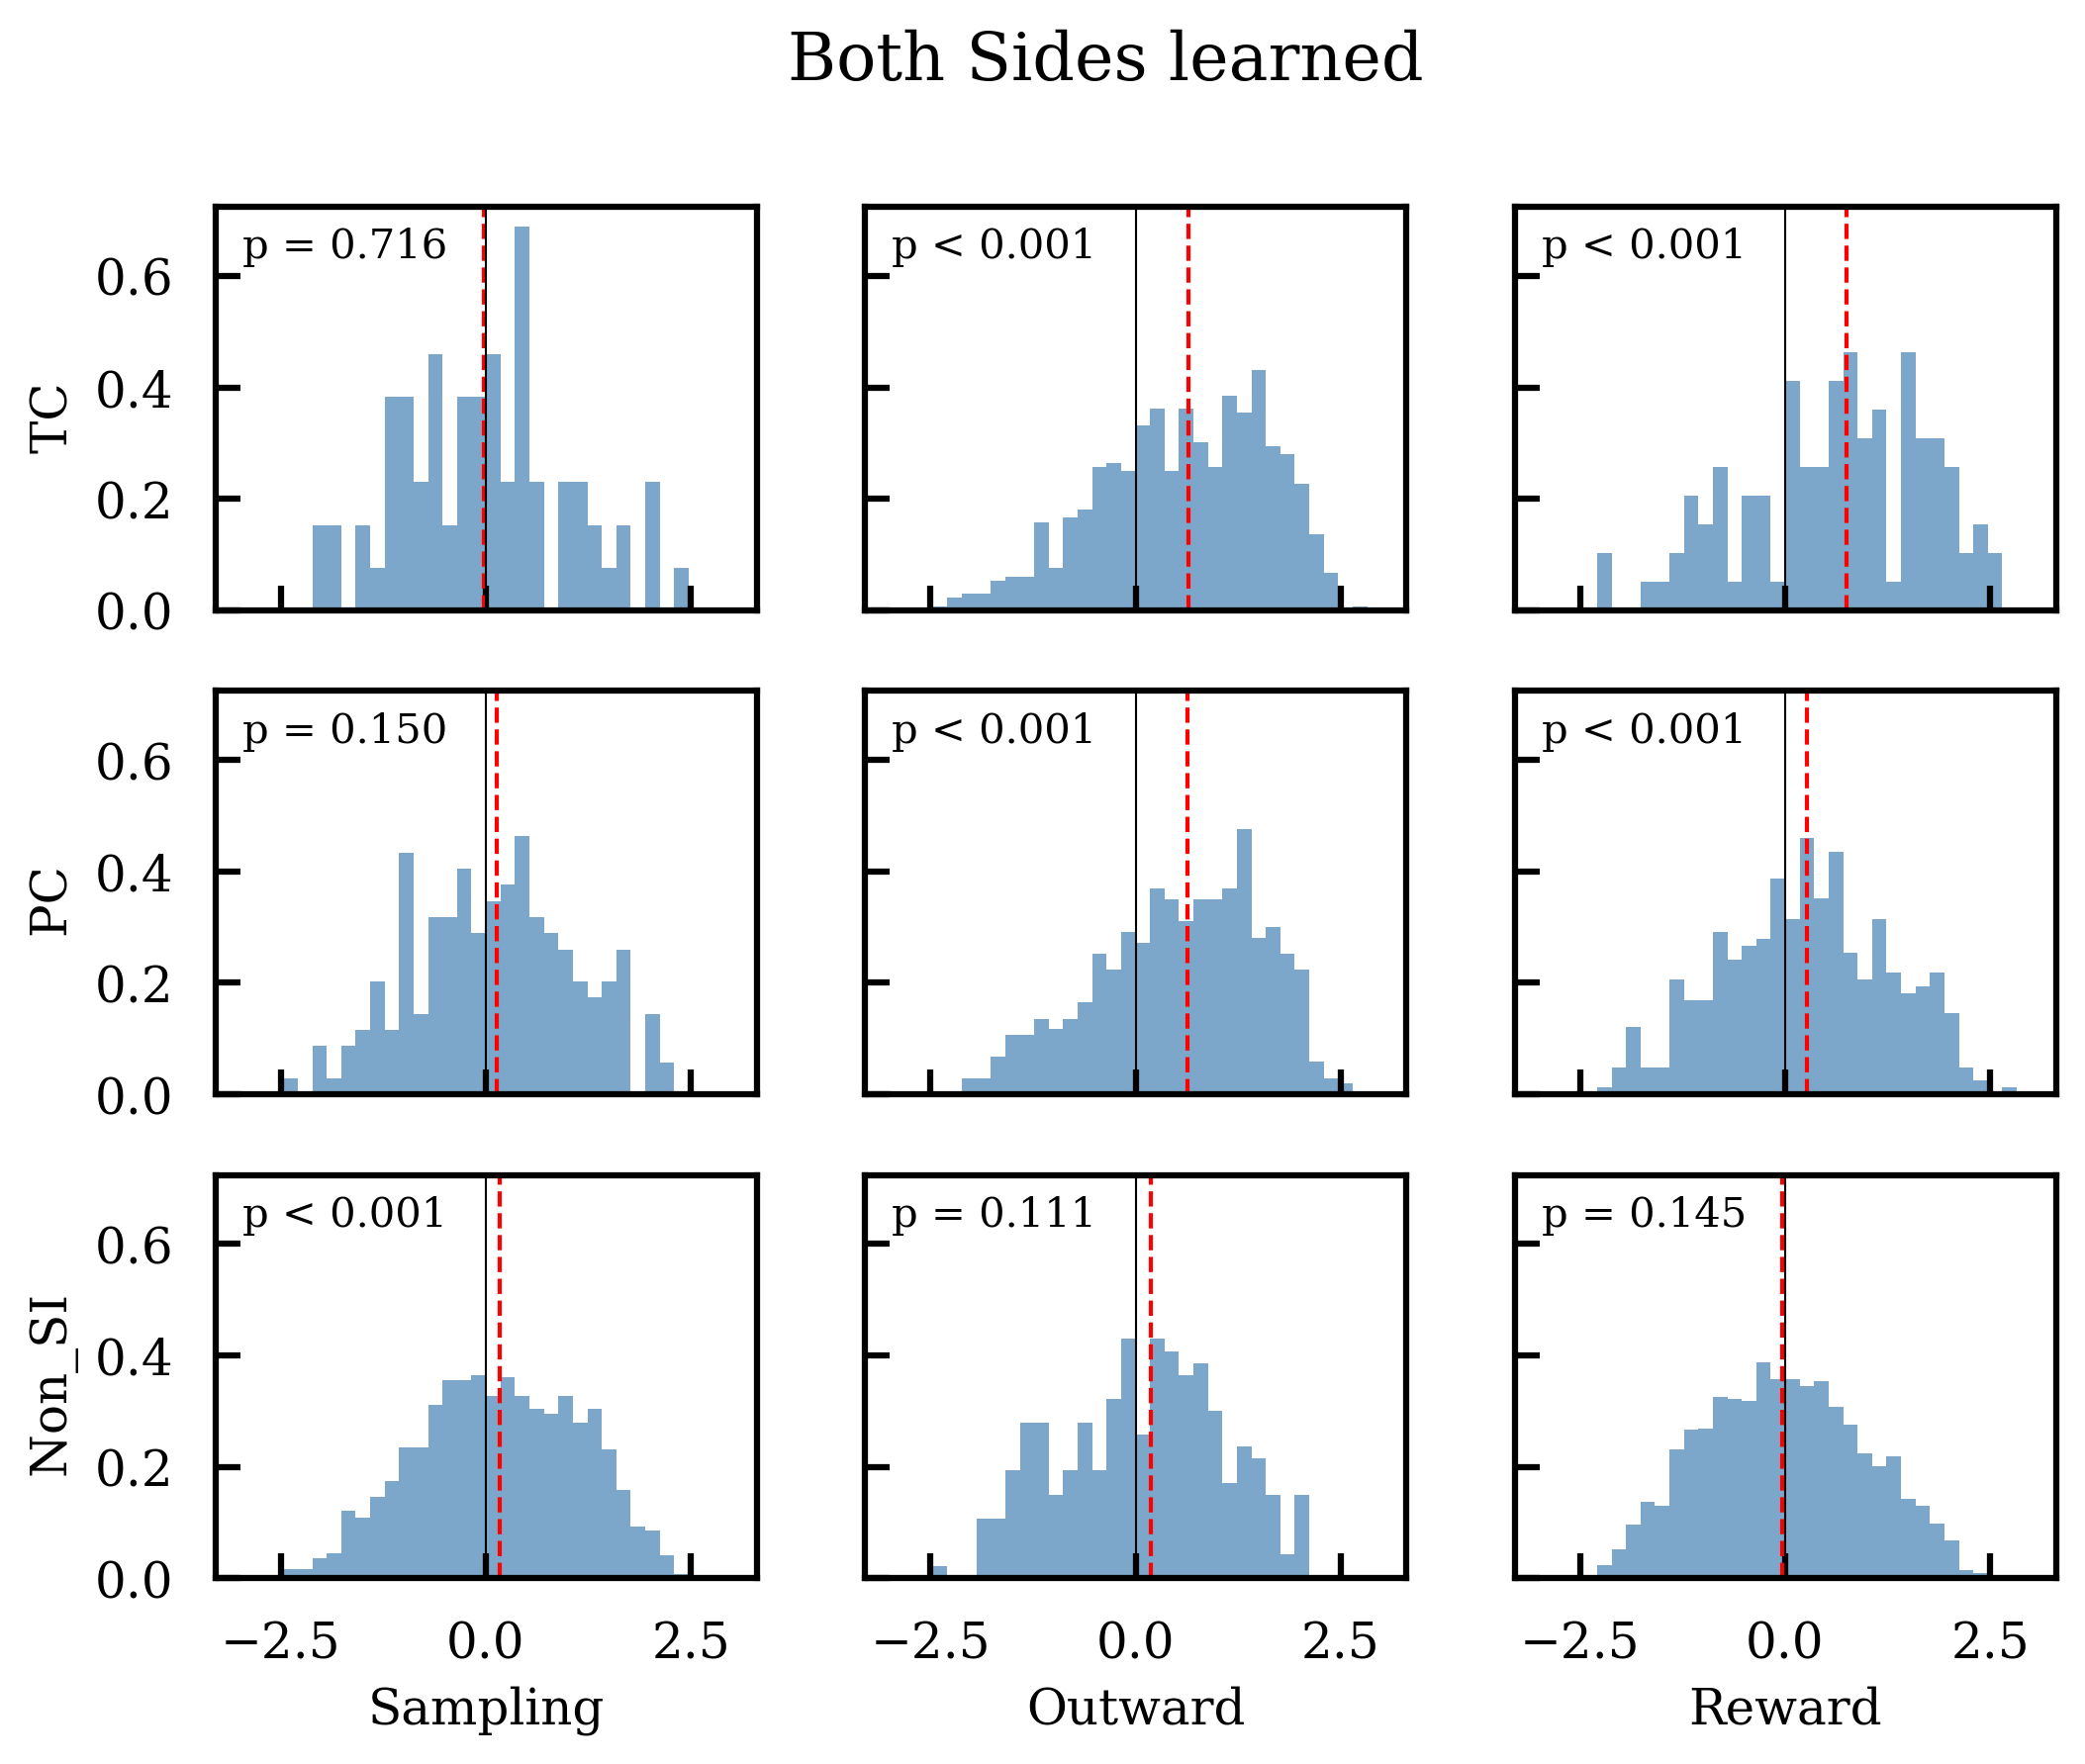

In [55]:
# Define sides (left and right) to create separate figures
sides = ['left', 'right']
contexts = ['sampling', 'outward', 'reward']
clusters = ['TC_cluster', 'PC_cluster', 'Non_SI_cluster']

results_all = {}  # Store stats, p-values, and n for each test

# Create separate figures for left and right sides
for phase in ['learning', 'learned']:
    results_dict = {}  # Store results for the current phase
    fig, axes = plt.subplots(len(clusters), len(contexts), figsize=(8, 6), sharex=True, sharey=True)
    fig.suptitle("Both Sides " + phase, fontsize=16)

    for i, cluster in enumerate(clusters):
        for j, context in enumerate(contexts):
            # Extract Z values
            z_values_l = pf.extract_z_values_by_context_cluster_side(replay_stats, phase, context, cluster, 'left')
            z_values_r = pf.extract_z_values_by_context_cluster_side(replay_stats, phase, context, cluster, 'right')
            z_values = np.concatenate((z_values_l, z_values_r))
            z_values = z_values[~np.isnan(z_values)]  # Remove NaNs
            
            # Perform the statistical test if enough data
            if len(z_values) > 1:  # Ensure there are enough values to perform the test
                stat, p_value = wilcoxon(z_values)
            else:
                stat, p_value = np.nan, np.nan  # Not enough data
            
            # Save the results in the dictionary
            key = f"{context}_{cluster}"
            results_dict[key] = {
                'stat': stat,
                'p_value': p_value,
                'n': len(z_values)
            }

            # Compute and plot histogram
            counts, bin_edges = np.histogram(z_values, bins=np.linspace(-3, 3, 35))
            bin_width = bin_edges[1] - bin_edges[0]
            pdf_values = counts / (np.sum(counts) * bin_width)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            axes[i, j].bar(bin_centers, pdf_values, width=bin_width, alpha=0.7, color='steelblue')

            # Add p-value text to the plot
            if p_value < 0.001:
                p_text = "p < 0.001"
            else:
                p_text = f"p = {p_value:.3f}"
            axes[i, j].text(0.05, 0.95, p_text, transform=axes[i, j].transAxes, 
                            fontsize=10, verticalalignment='top')

            # Mark median line
            if len(z_values) > 0:
                median_value = np.median(z_values)
                axes[i, j].axvline(median_value, color='r', linestyle='--', linewidth=1)
            axes[i, j].axvline(0, color='k', linewidth=0.5)

            # Label axes
            axes[i, 0].set_ylabel(f"{cluster.replace('_cluster', ' ')}", fontsize=12)
            axes[2, j].set_xlabel(f"{context.capitalize()}", fontsize=12)

    results_all[phase] = results_dict  # Store results for the phase

# Display or save the results table
import pandas as pd
for phase, results in results_all.items():
    df = pd.DataFrame.from_dict(results, orient='index')
    print(f"\nResults for phase: {phase}")
    print(df)


C:\Users\hamed\AppData\Local\Temp\ipykernel_26040\1298193255.py:83: RuntimeWarning: invalid value encountered in divide
  pdf = counts / (np.sum(counts) * bw)


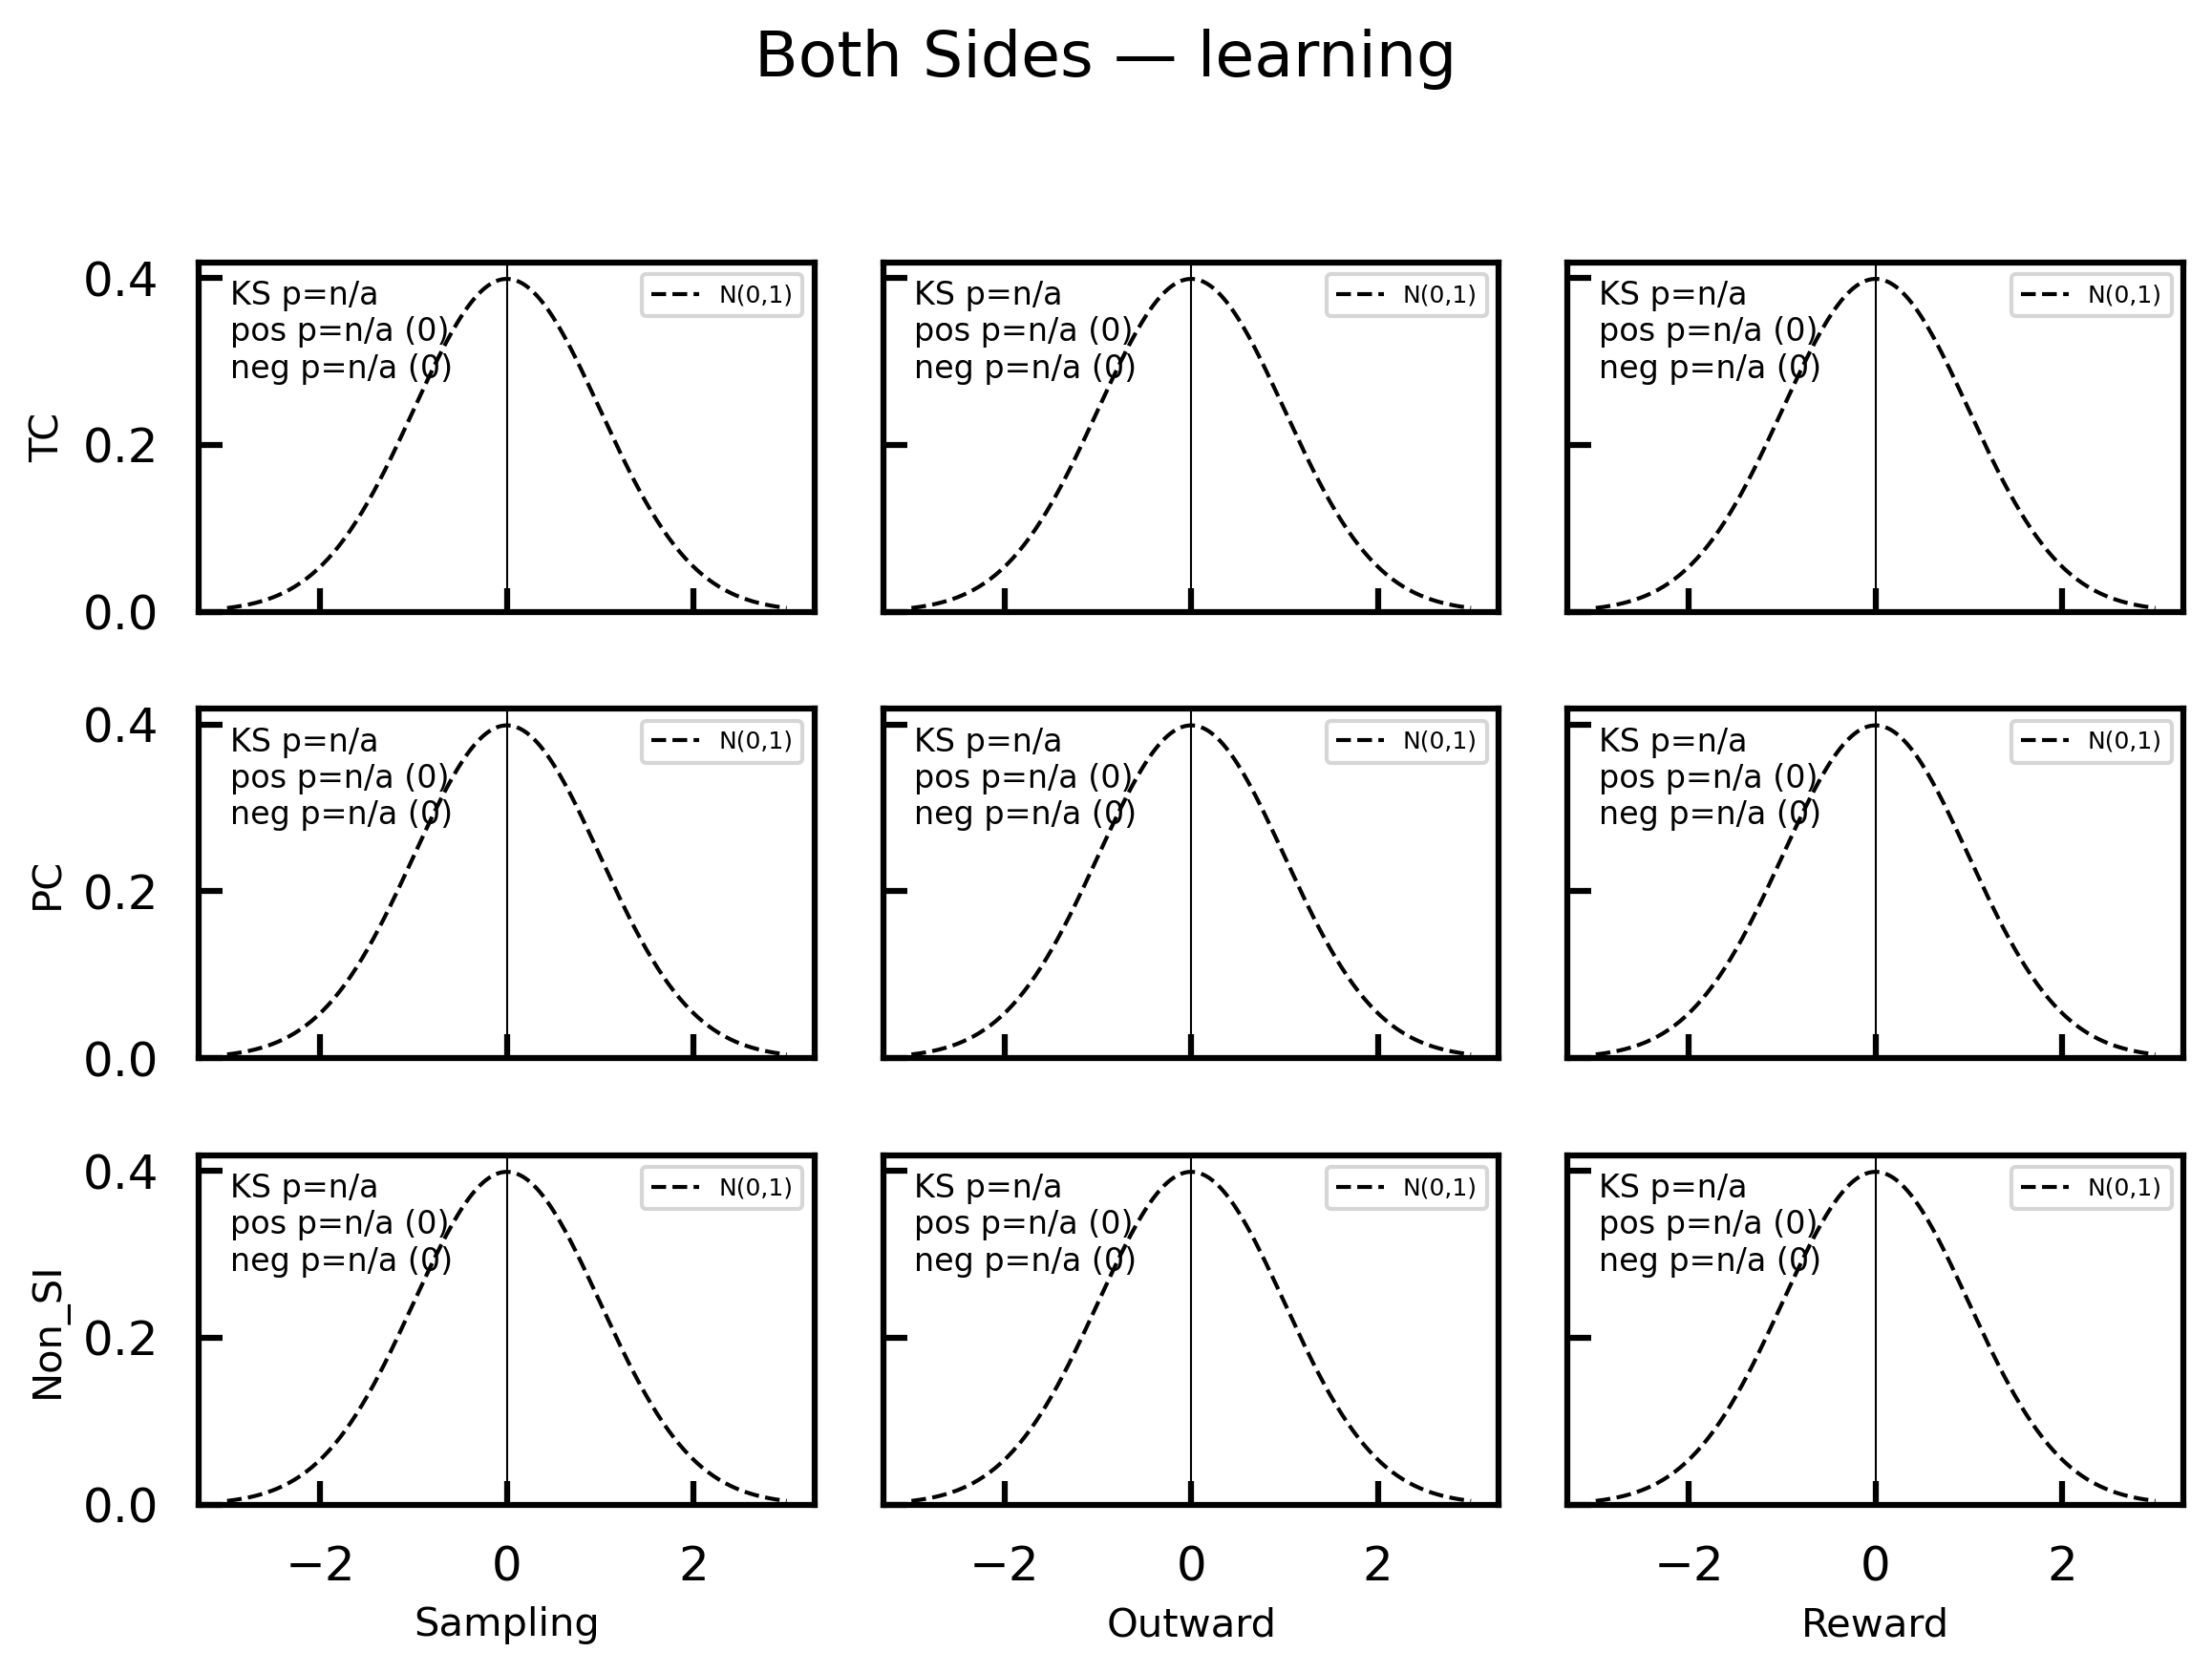

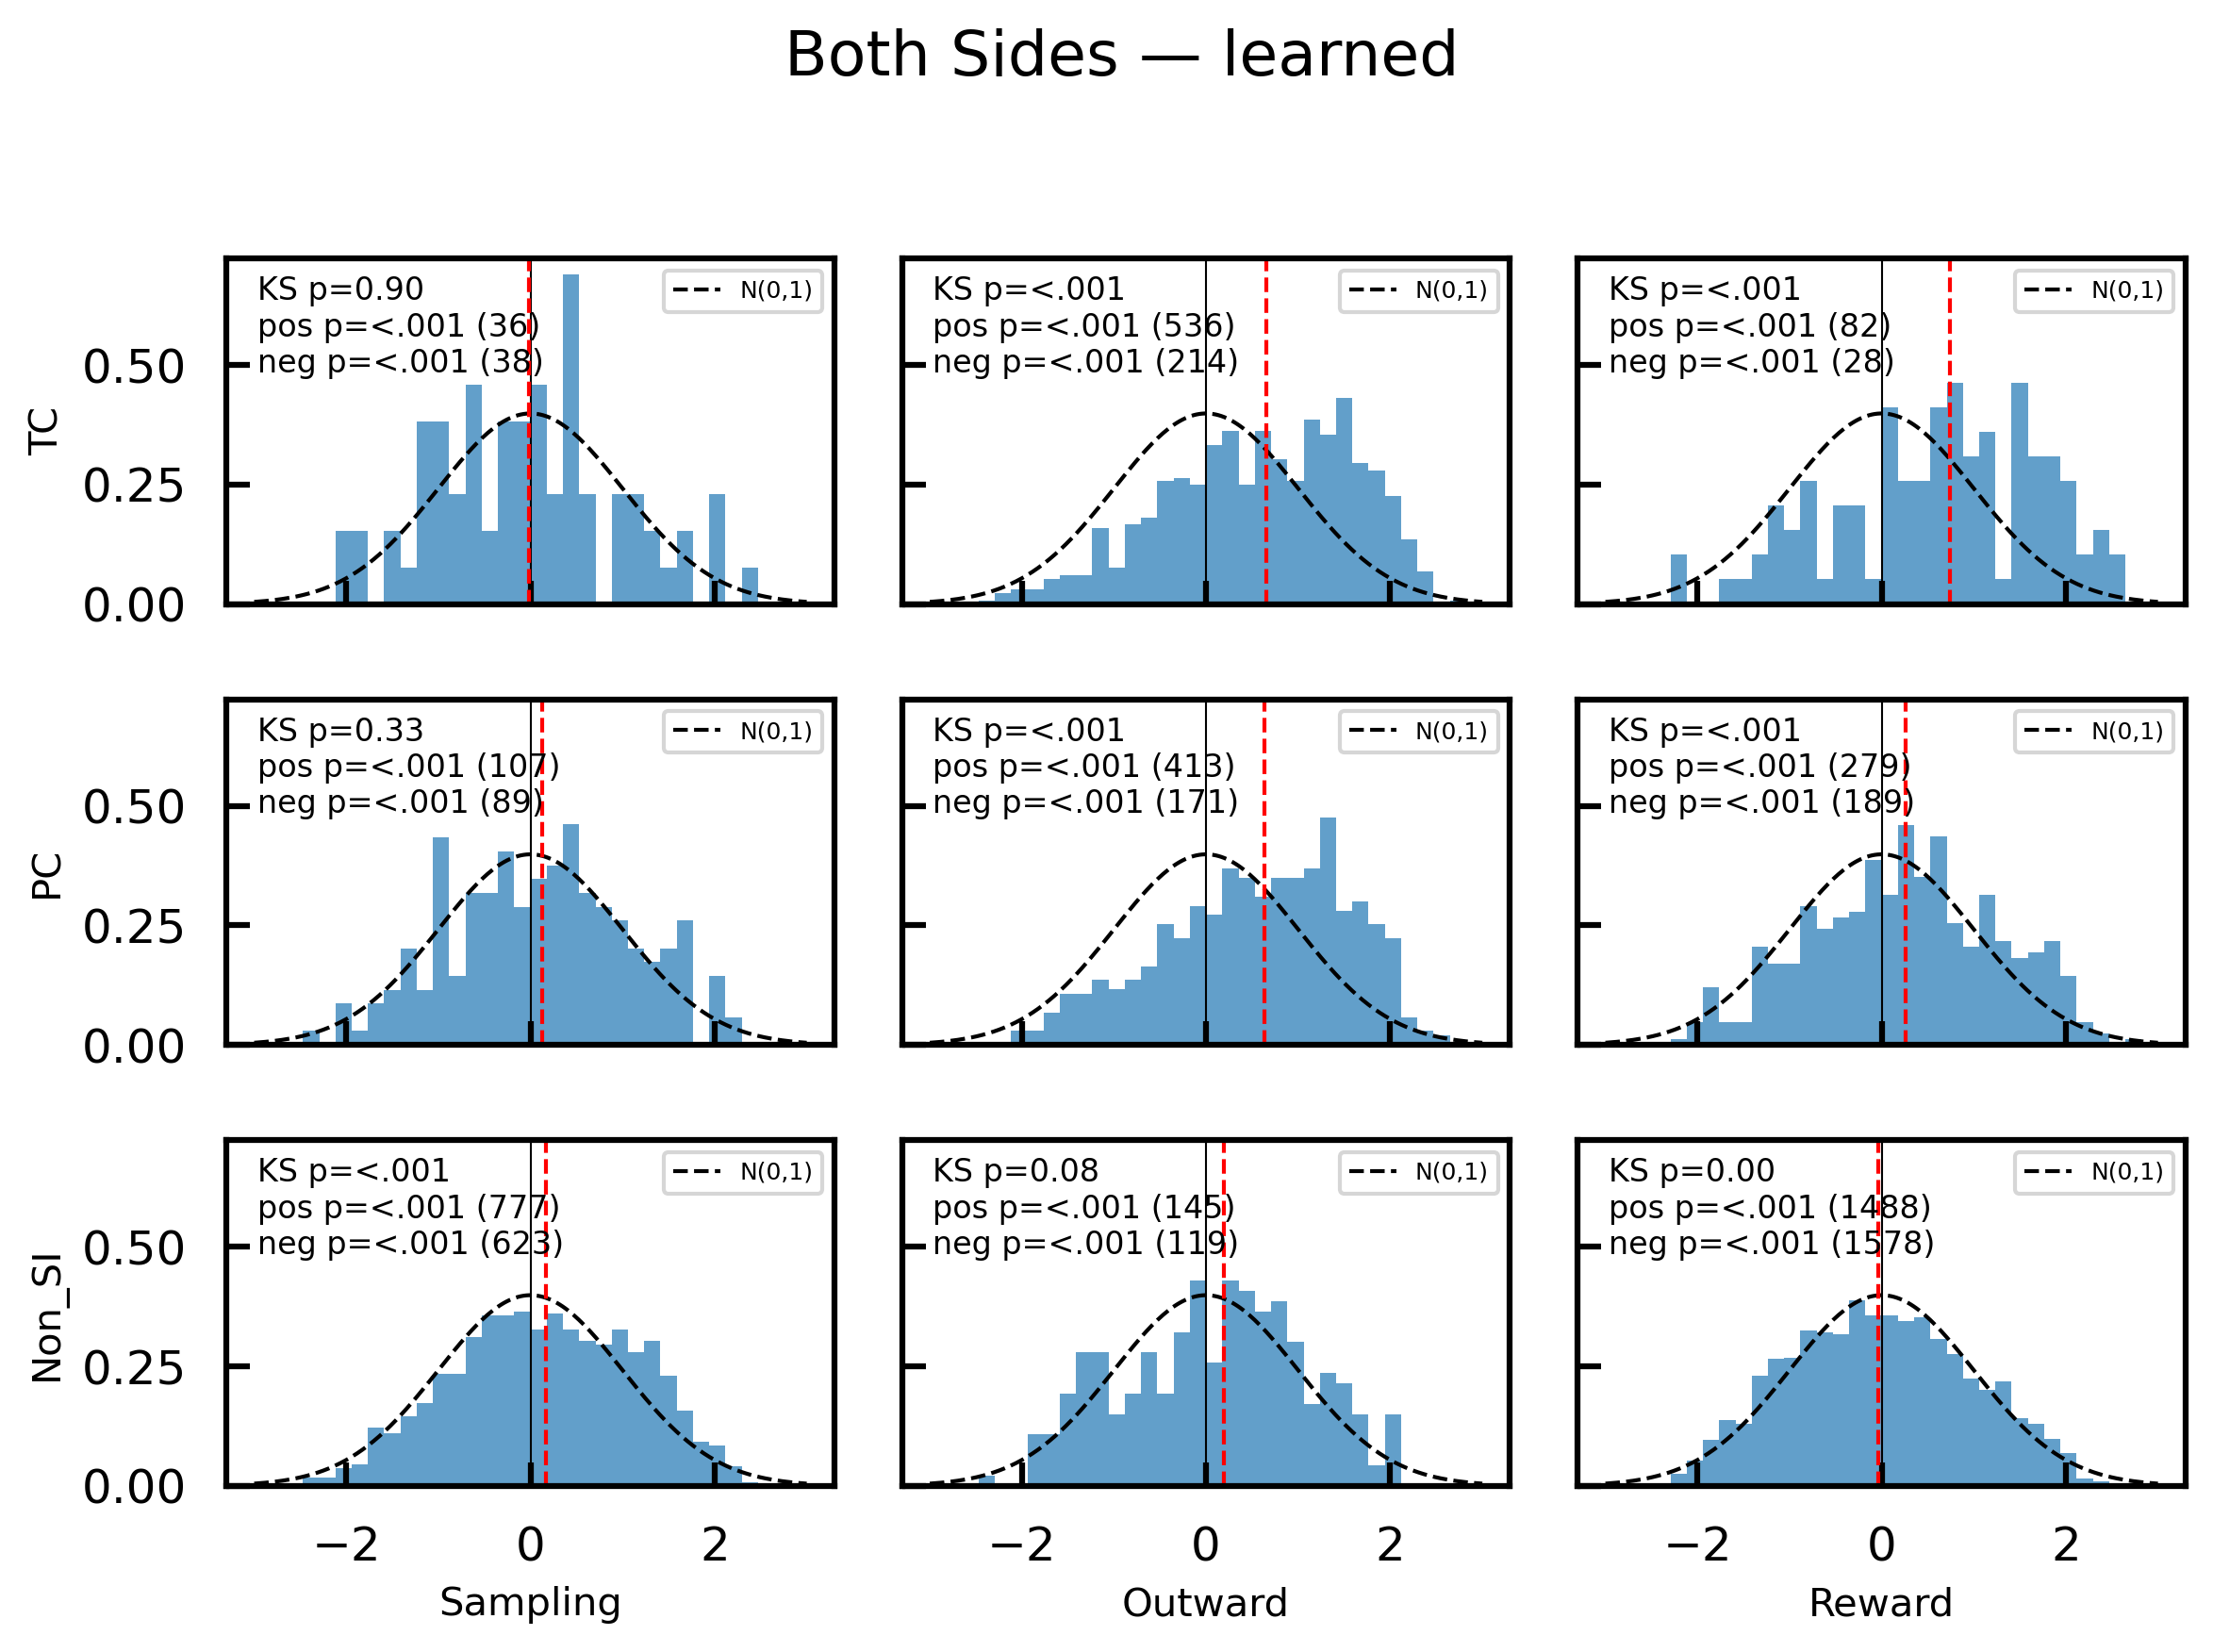


Results for phase: learning
                         n_total  n_pos  n_neg  median_z  ks_stat  ks_p  \
sampling_TC_cluster            0      0      0       NaN      NaN   NaN   
outward_TC_cluster             0      0      0       NaN      NaN   NaN   
reward_TC_cluster              0      0      0       NaN      NaN   NaN   
sampling_PC_cluster            0      0      0       NaN      NaN   NaN   
outward_PC_cluster             0      0      0       NaN      NaN   NaN   
reward_PC_cluster              0      0      0       NaN      NaN   NaN   
sampling_Non_SI_cluster        0      0      0       NaN      NaN   NaN   
outward_Non_SI_cluster         0      0      0       NaN      NaN   NaN   
reward_Non_SI_cluster          0      0      0       NaN      NaN   NaN   

                         p_pos  p_neg  
sampling_TC_cluster        NaN    NaN  
outward_TC_cluster         NaN    NaN  
reward_TC_cluster          NaN    NaN  
sampling_PC_cluster        NaN    NaN  
outward_PC_cluster  

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import kstest, wilcoxon, norm
# import pandas as pd

# # Helper to format p‐values
# def fmt_p(p):
#     if np.isnan(p):
#         return "n/a"
#     elif p < 0.001:
#         return "<.001"
#     else:
#         return f"{p:.2f}"

# # Define contexts and clusters
# contexts = ['sampling', 'outward', 'reward']
# clusters = ['TC_cluster', 'PC_cluster', 'Non_SI_cluster']

# # results_all will store stats for each phase
# results_all = {}

# # Loop over learning phases
# for phase in ['learning', 'learned']:
#     results_dict = {}
#     fig, axes = plt.subplots(
#         len(clusters), len(contexts),
#         figsize=(8, 6), sharex=True, sharey=True
#     )
#     fig.suptitle(f"Both Sides — {phase}", fontsize=16)

#     for i, cluster in enumerate(clusters):
#         for j, context in enumerate(contexts):
#             # Extract Z values from left and right
#             zl = pf.extract_z_values_by_context_cluster_side(
#                 replay_stats, phase, context, cluster, 'left'
#             )
#             zr = pf.extract_z_values_by_context_cluster_side(
#                 replay_stats, phase, context, cluster, 'right'
#             )
#             z = np.concatenate((zl, zr))
#             z = z[~np.isnan(z)]
#             n_total = len(z)

#             # Initialize stats
#             ks_stat = ks_p = p_pos = p_neg = median_z = np.nan
#             n_pos = n_neg = 0

#             if n_total > 0:
#                 # 1) KS-test vs N(0,1)
#                 ks_stat, ks_p = kstest(z, 'norm')

#                 # 2) split into forward (pos) and reverse (neg)
#                 z_pos = z[z > 0]
#                 z_neg = z[z < 0]
#                 n_pos, n_neg = len(z_pos), len(z_neg)

#                 # 3) Wilcoxon signed‐rank tests against 0
#                 if n_pos > 1:
#                     _, p_pos = wilcoxon(z_pos - 0, alternative='greater')
#                 if n_neg > 1:
#                     _, p_neg = wilcoxon(z_neg - 0, alternative='less')

#                 # 4) Median of the full distribution
#                 median_z = np.median(z)

#             # Store in results_dict
#             key = f"{context}_{cluster}"
#             results_dict[key] = {
#                 'n_total': n_total,
#                 'n_pos': n_pos,
#                 'n_neg': n_neg,
#                 'median_z': median_z,
#                 'ks_stat': ks_stat,
#                 'ks_p': ks_p,
#                 'p_pos': p_pos,
#                 'p_neg': p_neg
#             }

#             # Plot histogram
#             ax = axes[i, j]
#             counts, bins = np.histogram(z, bins=np.linspace(-3, 3, 35))
#             bw = bins[1] - bins[0]
#             pdf = counts / (np.sum(counts) * bw)
#             centers = (bins[:-1] + bins[1:]) / 2
#             ax.bar(centers, pdf, width=bw, alpha=0.7)

#             # Overlay N(0,1) PDF
#             xs = np.linspace(-3, 3, 200)
#             ax.plot(xs, norm.pdf(xs), 'k--', linewidth=1, label='N(0,1)')

#             # Vertical lines at 0 and median
#             ax.axvline(0, color='k', lw=0.5)
#             if not np.isnan(median_z):
#                 ax.axvline(median_z, color='r', ls='--', lw=1)

#             # Annotate p‐values with formatting
#             ks_txt  = fmt_p(ks_p)
#             pos_txt = fmt_p(p_pos)
#             neg_txt = fmt_p(p_neg)
#             txt = (
#                 f"KS p={ks_txt}\n"
#                 f"pos p={pos_txt} ({n_pos})\n"
#                 f"neg p={neg_txt} ({n_neg})"
#             )
#             ax.text(0.05, 0.95, txt, transform=ax.transAxes,
#                     fontsize=8, va='top')

#             # Labels
#             if j == 0:
#                 ax.set_ylabel(cluster.replace('_cluster', ''), fontsize=10)
#             if i == len(clusters) - 1:
#                 ax.set_xlabel(context.capitalize(), fontsize=10)

#             ax.legend(fontsize=6)

#     results_all[phase] = results_dict
#     plt.tight_layout(rect=[0, 0, 1, 0.96])
#     plt.show()

# # Print summary tables
# for phase, res in results_all.items():
#     df = pd.DataFrame.from_dict(res, orient='index')
#     print(f"\nResults for phase: {phase}")
#     print(df.round(3))


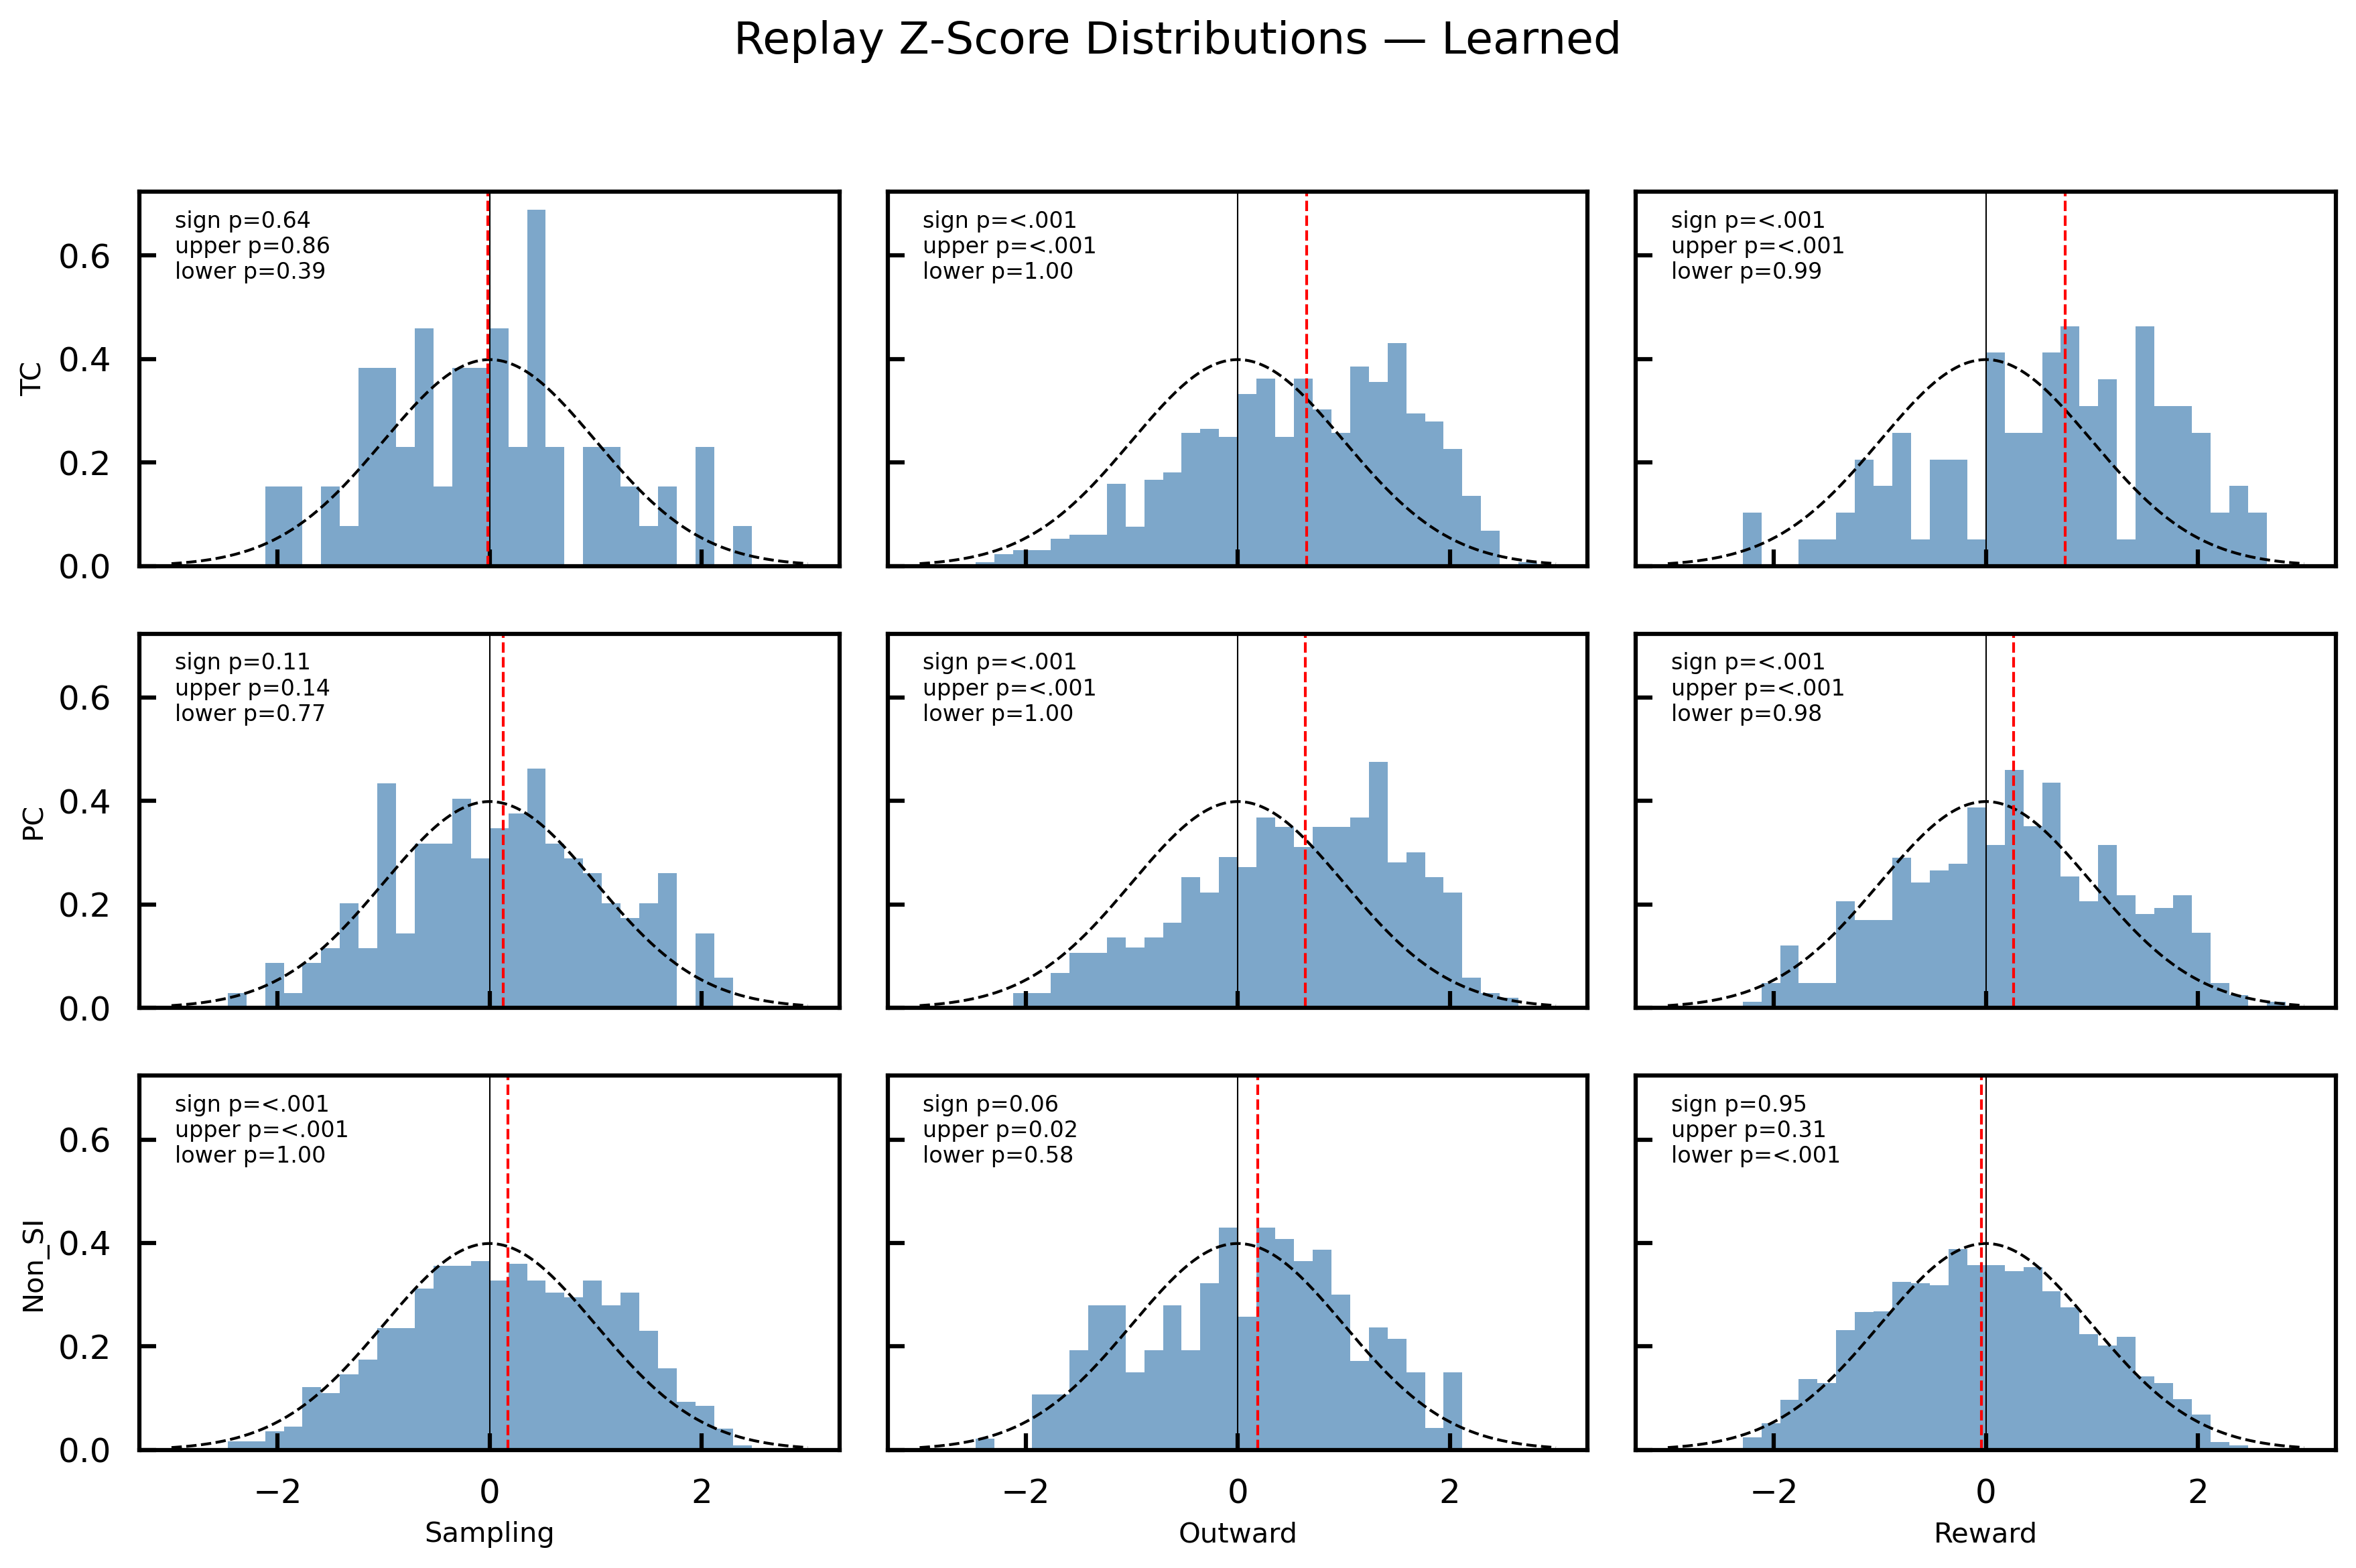


=== Phase: Learned ===
                         n_total  n_pos (z>0) sign‐test p  n_>75%ile  \
sampling_TC_cluster           74           36        0.64         15   
outward_TC_cluster           750          536       <.001        368   
reward_TC_cluster            110           82       <.001         57   
sampling_PC_cluster          196          107        0.11         56   
outward_PC_cluster           584          413       <.001        284   
reward_PC_cluster            468          279       <.001        155   
sampling_Non_SI_cluster     1400          777       <.001        464   
outward_Non_SI_cluster       264          145        0.06         82   
reward_Non_SI_cluster       3066         1488        0.95        779   

                        upper‐tail p  n_<25%ile lower‐tail p   SW p  median_z  
sampling_TC_cluster             0.86         20         0.39   0.56    -0.020  
outward_TC_cluster             <.001         91         1.00  <.001     0.650  
reward_TC_clust

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.stats import binomtest, norm, shapiro

# # Helper to format p‐values
# def fmt_p(p):
#     if np.isnan(p):
#         return "n/a"
#     elif p < 0.001:
#         return "<.001"
#     else:
#         return f"{p:.2f}"

# # Parameters
# contexts = ['sampling', 'outward', 'reward']
# clusters = ['TC_cluster', 'PC_cluster', 'Non_SI_cluster']
# phases = [ 'learned']
# th75 = norm.ppf(0.75)   # ~0.6745

# # Storage for summary statistics
# results_all = {}

# for phase in phases:
#     # Set up figure with one row per cluster and one column per context
#     fig, axes = plt.subplots(
#         nrows=len(clusters),
#         ncols=len(contexts),
#         figsize=(12, 8),
#         sharex=True,
#         sharey=True
#     )
#     fig.suptitle(f"Replay Z‐Score Distributions — {phase.capitalize()}", fontsize=16)
    
#     # Dict to hold this phase's results
#     phase_results = {}
    
#     for i, cluster in enumerate(clusters):
#         for j, context in enumerate(contexts):
#             # Extract Z‐scores from left and right
#             zl = pf.extract_z_values_by_context_cluster_side(
#                 replay_stats, phase, context, cluster, 'left'
#             )
#             zr = pf.extract_z_values_by_context_cluster_side(
#                 replay_stats, phase, context, cluster, 'right'
#             )
#             z = np.concatenate((zl, zr))
#             z = z[~np.isnan(z)]
#             n = len(z)
            
#             # Initialize metrics
#             n_pos = n_high = n_low = np.nan
#             p_sign = p_high = p_low = sw_p = np.nan
#             median_z = np.nan
            
#             if n > 0:
#                 # 1) Sign‐test: are there more forward events (z>0) than reverse?
#                 n_pos = np.sum(z > 0)
#                 p_sign = binomtest(n_pos, n, p=0.5, alternative='greater').pvalue
                
#                 # 2) Upper‐tail test: more events above +75th percentile than expected?
#                 n_high = np.sum(z > th75)
#                 p_high = binomtest(n_high, n, p=0.25, alternative='greater').pvalue
                
#                 # 3) Lower‐tail test: more events below −75th percentile than expected?
#                 n_low = np.sum(z < -th75)
#                 p_low = binomtest(n_low, n, p=0.25, alternative='greater').pvalue
                
#                 # 4) Normality test (Shapiro–Wilk)
#                 if 3 <= n <= 5000:
#                     sw_p = shapiro(z).pvalue
                
#                 # 5) Median of the full distribution
#                 median_z = np.median(z)
            
#             # Save statistics
#             key = f"{context}_{cluster}"
#             phase_results[key] = {
#                 'n_total':      n,
#                 'n_pos (z>0)':  n_pos,
#                 'sign‐test p':  fmt_p(p_sign),
#                 'n_>75%ile':    n_high,
#                 'upper‐tail p': fmt_p(p_high),
#                 'n_<25%ile':    n_low,
#                 'lower‐tail p': fmt_p(p_low),
#                 'SW p':         fmt_p(sw_p),
#                 'median_z':     round(median_z, 3)
#             }
            
#             # Plot histogram + normal overlay
#             ax = axes[i, j]
#             bins = np.linspace(-3, 3, 35)
#             counts, edges = np.histogram(z, bins=bins)
#             bw = edges[1] - edges[0]
#             pdf = counts / (counts.sum() * bw)
#             centers = (edges[:-1] + edges[1:]) / 2
            
#             ax.bar(centers, pdf, width=bw, alpha=0.7,rasterized=True, color='steelblue')
#             xs = np.linspace(-3, 3, 200)
#             ax.plot(xs, norm.pdf(xs), 'k--', linewidth=1, )
            
#             # Add vertical lines at zero and median
#             ax.axvline(0, color='k', lw=0.5)
#             if not np.isnan(median_z):
#                 ax.axvline(median_z, color='r', ls='--', lw=1)
            
#             # Annotate p‐values
#             txt = (
#                 f"sign p={fmt_p(p_sign)}\n"
#                 f"upper p={fmt_p(p_high)}\n"
#                 f"lower p={fmt_p(p_low)}"
#             )
#             ax.text(0.05, 0.95, txt, transform=ax.transAxes,
#                     fontsize=8, va='top')
            
#             # Label axes
#             if j == 0:
#                 ax.set_ylabel(cluster.replace('_cluster', ''), fontsize=10)
#             if i == len(clusters) - 1:
#                 ax.set_xlabel(context.capitalize(), fontsize=10)
            
#             #ax.legend(fontsize=6, loc='upper right')
    
#     plt.tight_layout(rect=[0, 0, 1, 0.96])
#     plt.show()
#     fig.savefig(join(savefolder,f'Z_scores_{phase}.svg'),
#              dpi=300, format='svg', bbox_inches='tight')
#     # Store phase results
#     results_all[phase] = phase_results

# # Print summary tables for each phase
# for phase, stats in results_all.items():
#     print(f"\n=== Phase: {phase.capitalize()} ===")
#     df = pd.DataFrame.from_dict(stats, orient='index')
#     print(df)




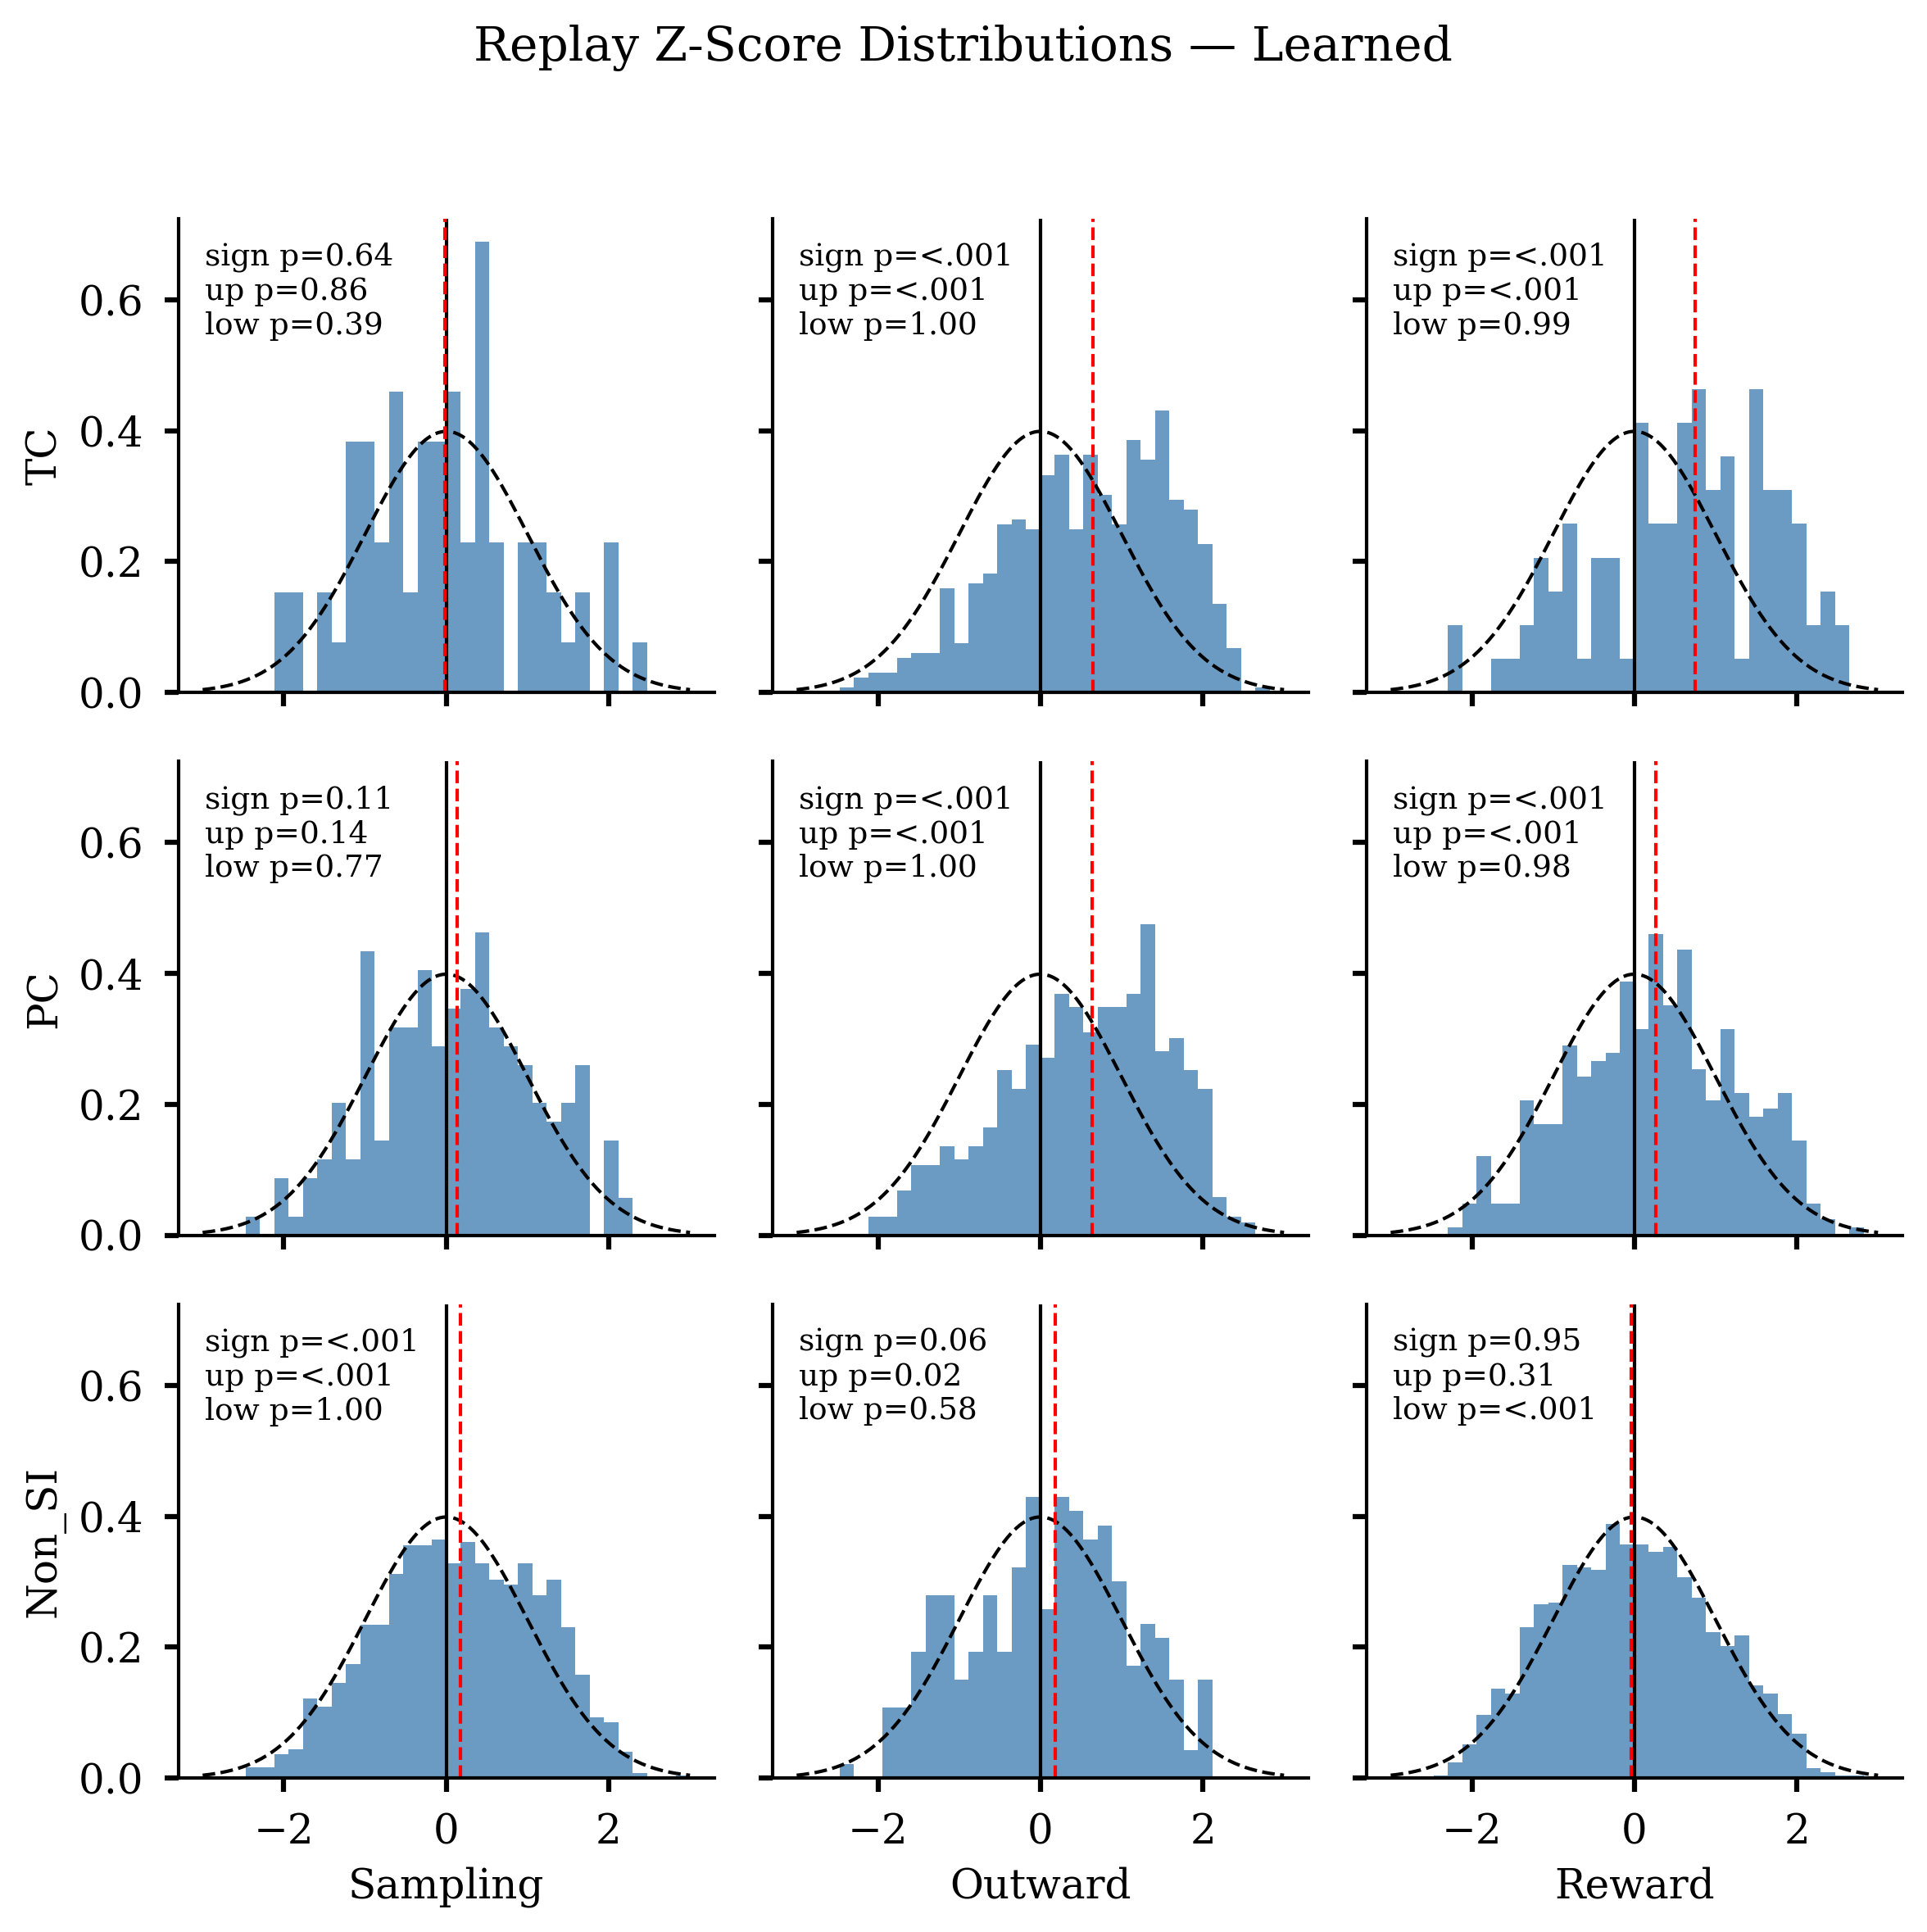


=== Phase: Learned ===
                         n_total  n_pos (z>0) sign-test p  n_>75%ile  \
sampling_TC_cluster           74           36        0.64         15   
outward_TC_cluster           750          536       <.001        368   
reward_TC_cluster            110           82       <.001         57   
sampling_PC_cluster          196          107        0.11         56   
outward_PC_cluster           584          413       <.001        284   
reward_PC_cluster            468          279       <.001        155   
sampling_Non_SI_cluster     1400          777       <.001        464   
outward_Non_SI_cluster       264          145        0.06         82   
reward_Non_SI_cluster       3066         1488        0.95        779   

                        upper-tail p  n_<25%ile lower-tail p   SW p  median_z  
sampling_TC_cluster             0.86         20         0.39   0.56    -0.020  
outward_TC_cluster             <.001         91         1.00  <.001     0.650  
reward_TC_clust

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binomtest, norm, shapiro

# Manuscript rcParams
plt.rcParams.update({
    
    'font.size':      12,
    'axes.linewidth': 1.0,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.major.size':4,
    'ytick.major.size':4,
    'figure.dpi':     300
})

# Helper to format p‐values
def fmt_p(p):
    if np.isnan(p):
        return "n/a"
    elif p < 0.001:
        return "<.001"
    else:
        return f"{p:.2f}"

# Parameters
contexts = ['sampling', 'outward', 'reward']
clusters = ['TC_cluster', 'PC_cluster', 'Non_SI_cluster']
phases   = ['learned']
th75     = norm.ppf(0.75)  # ~0.6745

results_all = {}

for phase in phases:
    fig, axes = plt.subplots(
        nrows=len(clusters), ncols=len(contexts),
        figsize=(8, 8), sharex=True, sharey=True
    )
    fig.suptitle(f"Replay Z-Score Distributions — {phase.capitalize()}", fontsize=14)
    
    phase_stats = {}
    for i, cluster in enumerate(clusters):
        for j, context in enumerate(contexts):
            # pull Z-scores
            zl = pf.extract_z_values_by_context_cluster_side(
                replay_stats, phase, context, cluster, 'left'
            )
            zr = pf.extract_z_values_by_context_cluster_side(
                replay_stats, phase, context, cluster, 'right'
            )
            z = np.concatenate((zl, zr))
            z = z[~np.isnan(z)]
            n = len(z)
            
            # init stats
            n_pos = n_high = n_low = np.nan
            p_sign = p_high = p_low = sw_p = np.nan
            median_z = np.nan
            
            if n > 0:
                n_pos    = np.sum(z > 0)
                p_sign   = binomtest(n_pos, n, p=0.5, alternative='greater').pvalue
                n_high   = np.sum(z > th75)
                p_high   = binomtest(n_high, n, p=0.25, alternative='greater').pvalue
                n_low    = np.sum(z < -th75)
                p_low    = binomtest(n_low, n, p=0.25, alternative='greater').pvalue
                if 3 <= n <= 5000:
                    sw_p = shapiro(z).pvalue
                median_z = np.median(z)
            
            # save stats
            key = f"{context}_{cluster}"
            phase_stats[key] = {
                'n_total':      n,
                'n_pos (z>0)':  n_pos,
                'sign-test p':  fmt_p(p_sign),
                'n_>75%ile':    n_high,
                'upper-tail p': fmt_p(p_high),
                'n_<25%ile':    n_low,
                'lower-tail p': fmt_p(p_low),
                'SW p':         fmt_p(sw_p),
                'median_z':     round(median_z,3)
            }
            
            # plot
            ax = axes[i, j]
            bins = np.linspace(-3, 3, 35)
            counts, edges = np.histogram(z, bins=bins)
            bw = edges[1]-edges[0]
            pdf = counts / (counts.sum()*bw)
            centers = (edges[:-1] + edges[1:]) / 2
            
            # histogram
            ax.bar(centers, pdf, width=bw, alpha=0.8, label='_nolegend_',rasterized=True, color='steelblue')
            # normal overlay
            xs = np.linspace(-3, 3, 200)
            ax.plot(xs, norm.pdf(xs), 'k--', lw=1, label='_nolegend_',)
            # annotate N(0,1)
            #ax.text(0.6, 0.8, 'N(0,1)', transform=ax.transAxes, fontsize=10)
            
            # zero & median lines
            ax.axvline(0,      color='k', lw=1, ls='-')
            if not np.isnan(median_z):
                ax.axvline(median_z, color='r', lw=1, ls='--')
            
            # p-value text
            txt = (
                f"sign p={fmt_p(p_sign)}\n"
                f"up p={fmt_p(p_high)}\n"
                f"low p={fmt_p(p_low)}"
            )
            ax.text(0.05, 0.95, txt, transform=ax.transAxes,
                    fontsize=9, va='top')
            
            # panel labels (optional)
            # label = chr(65 + i*len(contexts) + j)  # A, B, C...
            # ax.text(0.02, 0.98, label, transform=ax.transAxes,
            #         fontsize=12, weight='bold', va='top')
            
            # spines & ticks
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.tick_params(axis='both', which='major', pad=6)
            
            # axis labels
            if j == 0:
                ax.set_ylabel(cluster.replace('_cluster',''), fontsize=12)
            if i == len(clusters)-1:
                ax.set_xlabel(context.capitalize(), fontsize=12)
    
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()
    fig.savefig(join(savefolder,f'Z_scores_{phase}.svg'),
             dpi=300, format='svg', bbox_inches='tight')
    results_all[phase] = phase_stats

# summary tables
for phase, stats in results_all.items():
    print(f"\n=== Phase: {phase.capitalize()} ===")
    print(pd.DataFrame.from_dict(stats, orient='index'))
